In [1]:
import numpy as np
import pandas as pd
from functools import reduce
import importlib
import datetime as dt
from datetime import datetime
from pandas import concat
from math import sqrt
from sklearn import metrics
from sklearn import preprocessing as prep
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_pinball_loss as pinball
from matplotlib.pyplot import figure
from epftoolbox.evaluation import sMAPE
import matplotlib.pyplot as plt
import os
import matplotlib as mpl
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import rankdata
from sklearn.metrics import log_loss
from scipy.stats import chi2
from scipy.stats import rankdata
import warnings
import vartests
from vartests import kupiec_test

warnings.filterwarnings('ignore')

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)
def pinball(y_true, quantile_forecast, alpha):
    pinball_loss = np.maximum((y_true - quantile_forecast) * alpha, (quantile_forecast - y_true) * (1 - alpha))
    return np.mean(pinball_loss)
def winkler_score(y_true, lower_bound, upper_bound, alpha):
    if alpha == 0.3 or alpha == 0.7:
        alpha = 0.4
    elif alpha == 0.1 or alpha == 0.9:
        alpha = 0.8   
    y_true = np.array(y_true)
    lower_bound = np.array(lower_bound)
    upper_bound = np.array(upper_bound)
    B_t_h = upper_bound - lower_bound
    within_interval = (y_true >= lower_bound) & (y_true <= upper_bound)    
    score = np.zeros_like(y_true, dtype=float)    
    if alpha == 0.5:
        score += np.where(within_interval, 0.5 * B_t_h, 0)  # Condition 1 (special case for alpha=0.5)
    else:
        score += np.where(within_interval, B_t_h, 0)  # Condition 1
    score += np.where(y_true < lower_bound, (2 / alpha) * (lower_bound - y_true), 0)  # Condition 2
    score += np.where(y_true > upper_bound, (2 / alpha) * (y_true - upper_bound), 0)  # Condition 3
    winkler_score = np.mean(score)
    return winkler_score
def calculate_picp(y_true, lower_bound, upper_bound, alpha):
    if alpha == 0.5:
        within_interval = np.greater_equal(y_true, lower_bound)
    else:
        within_interval = np.logical_and(lower_bound <= y_true, y_true <= upper_bound)    
    picp = np.mean(within_interval)
    return picp
def calculate_uc_cc(y_true, lower_bound, upper_bound):
    within_interval = np.logical_and(lower_bound <= y_true, y_true <= upper_bound)
    uc = np.mean(within_interval)    
    independence = np.mean(np.logical_and(lower_bound <= y_true.shift(1), y_true.shift(1) <= upper_bound))
    cc = uc - independence    
    return uc
def assess_prediction_intervals(y_true, lower_bound, upper_bound, alpha=0.05):
    within_interval = np.logical_and(lower_bound <= y_true, y_true <= upper_bound)
    empirical_coverage = np.mean(within_interval)
    sharpness = np.mean(upper_bound - lower_bound)
    return empirical_coverage
def calculate_additional_metrics(y_true, lower_bound, upper_bound, alpha):
    reliability = assess_prediction_intervals(y_true, lower_bound, upper_bound)
    winkler = winkler_score(y_true, lower_bound, upper_bound, alpha)
    width = np.abs(upper_bound - lower_bound).mean().values[0]
    picp = calculate_picp(y_true, lower_bound, upper_bound, alpha)
    uc = calculate_uc_cc(y_true, lower_bound, upper_bound)
    return  winkler, width, picp, uc

def calculate_violations(y_true, lower_quantile_forecast, upper_quantile_forecast):
    violations = (y_true < lower_quantile_forecast) | (y_true > upper_quantile_forecast)
    return violations.astype(int)  # Convert True/False to 1/0

def calculate_total_violations(y_true_list, lower_quantile_forecast_list, upper_quantile_forecast_list):
    all_violations = pd.DataFrame()

    for y_true, lower_quantile_forecast, upper_quantile_forecast in zip(y_true_list, lower_quantile_forecast_list, upper_quantile_forecast_list):
        violations = calculate_violations(y_true, lower_quantile_forecast, upper_quantile_forecast)
        all_violations = pd.concat([all_violations, violations], axis=1)

    total_violations = all_violations.sum(axis=1)
    return total_violations, all_violations

def perform_kupiec_test(all_violations, var_conf_level=0.99, conf_level=0.95):
    result = kupiec_test(all_violations, var_conf_level=var_conf_level, conf_level=conf_level)
    return result

/home/ciaran/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


0.2.2


Performance Metrics for Quantile RMSE:
RMSE: 79.53
RMSE: 71.45
RMSE: 64.63
RMSE: 59.47
RMSE: 70.53
RMSE: 69.12

Performance Metrics for Quantile MAE:
MAE: 53.45
MAE: 43.39
MAE: 37.14
MAE: 35.93
MAE: 53.15
MAE: 44.61

Performance Metrics for Quantile Pinball Score:
Pinball Score: 7.08
Pinball Score: 14.52
Pinball Score: 18.57
Pinball Score: 18.51
Pinball Score: 11.78
Pinball Score: 14.09

Performance Metrics for Quantile sMAPE:
sMAPE: nan
sMAPE: nan
sMAPE: nan
sMAPE: 67.28
sMAPE: 80.62
sMAPE: 73.95

Performance Metrics for Quantile Winkler Score:
Winkler Score: 91.71
Winkler Score: 128.78
Winkler Score: 148.54
Winkler Score: 281.22
Winkler Score: 240.89
Winkler Score: 123.01

Performance Metrics for Quantile Mean Width:
Mean Width: 86.11
Mean Width: 33.16
Mean Width: 0.00
Mean Width: 33.16
Mean Width: 86.11
Mean Width: 59.64

Performance Metrics for Quantile coverage:
coverage: 0.76
coverage: 0.39
coverage: 0.64
coverage: 0.00
coverage: 0.00
coverage: 0.60

Total hours that reject the n

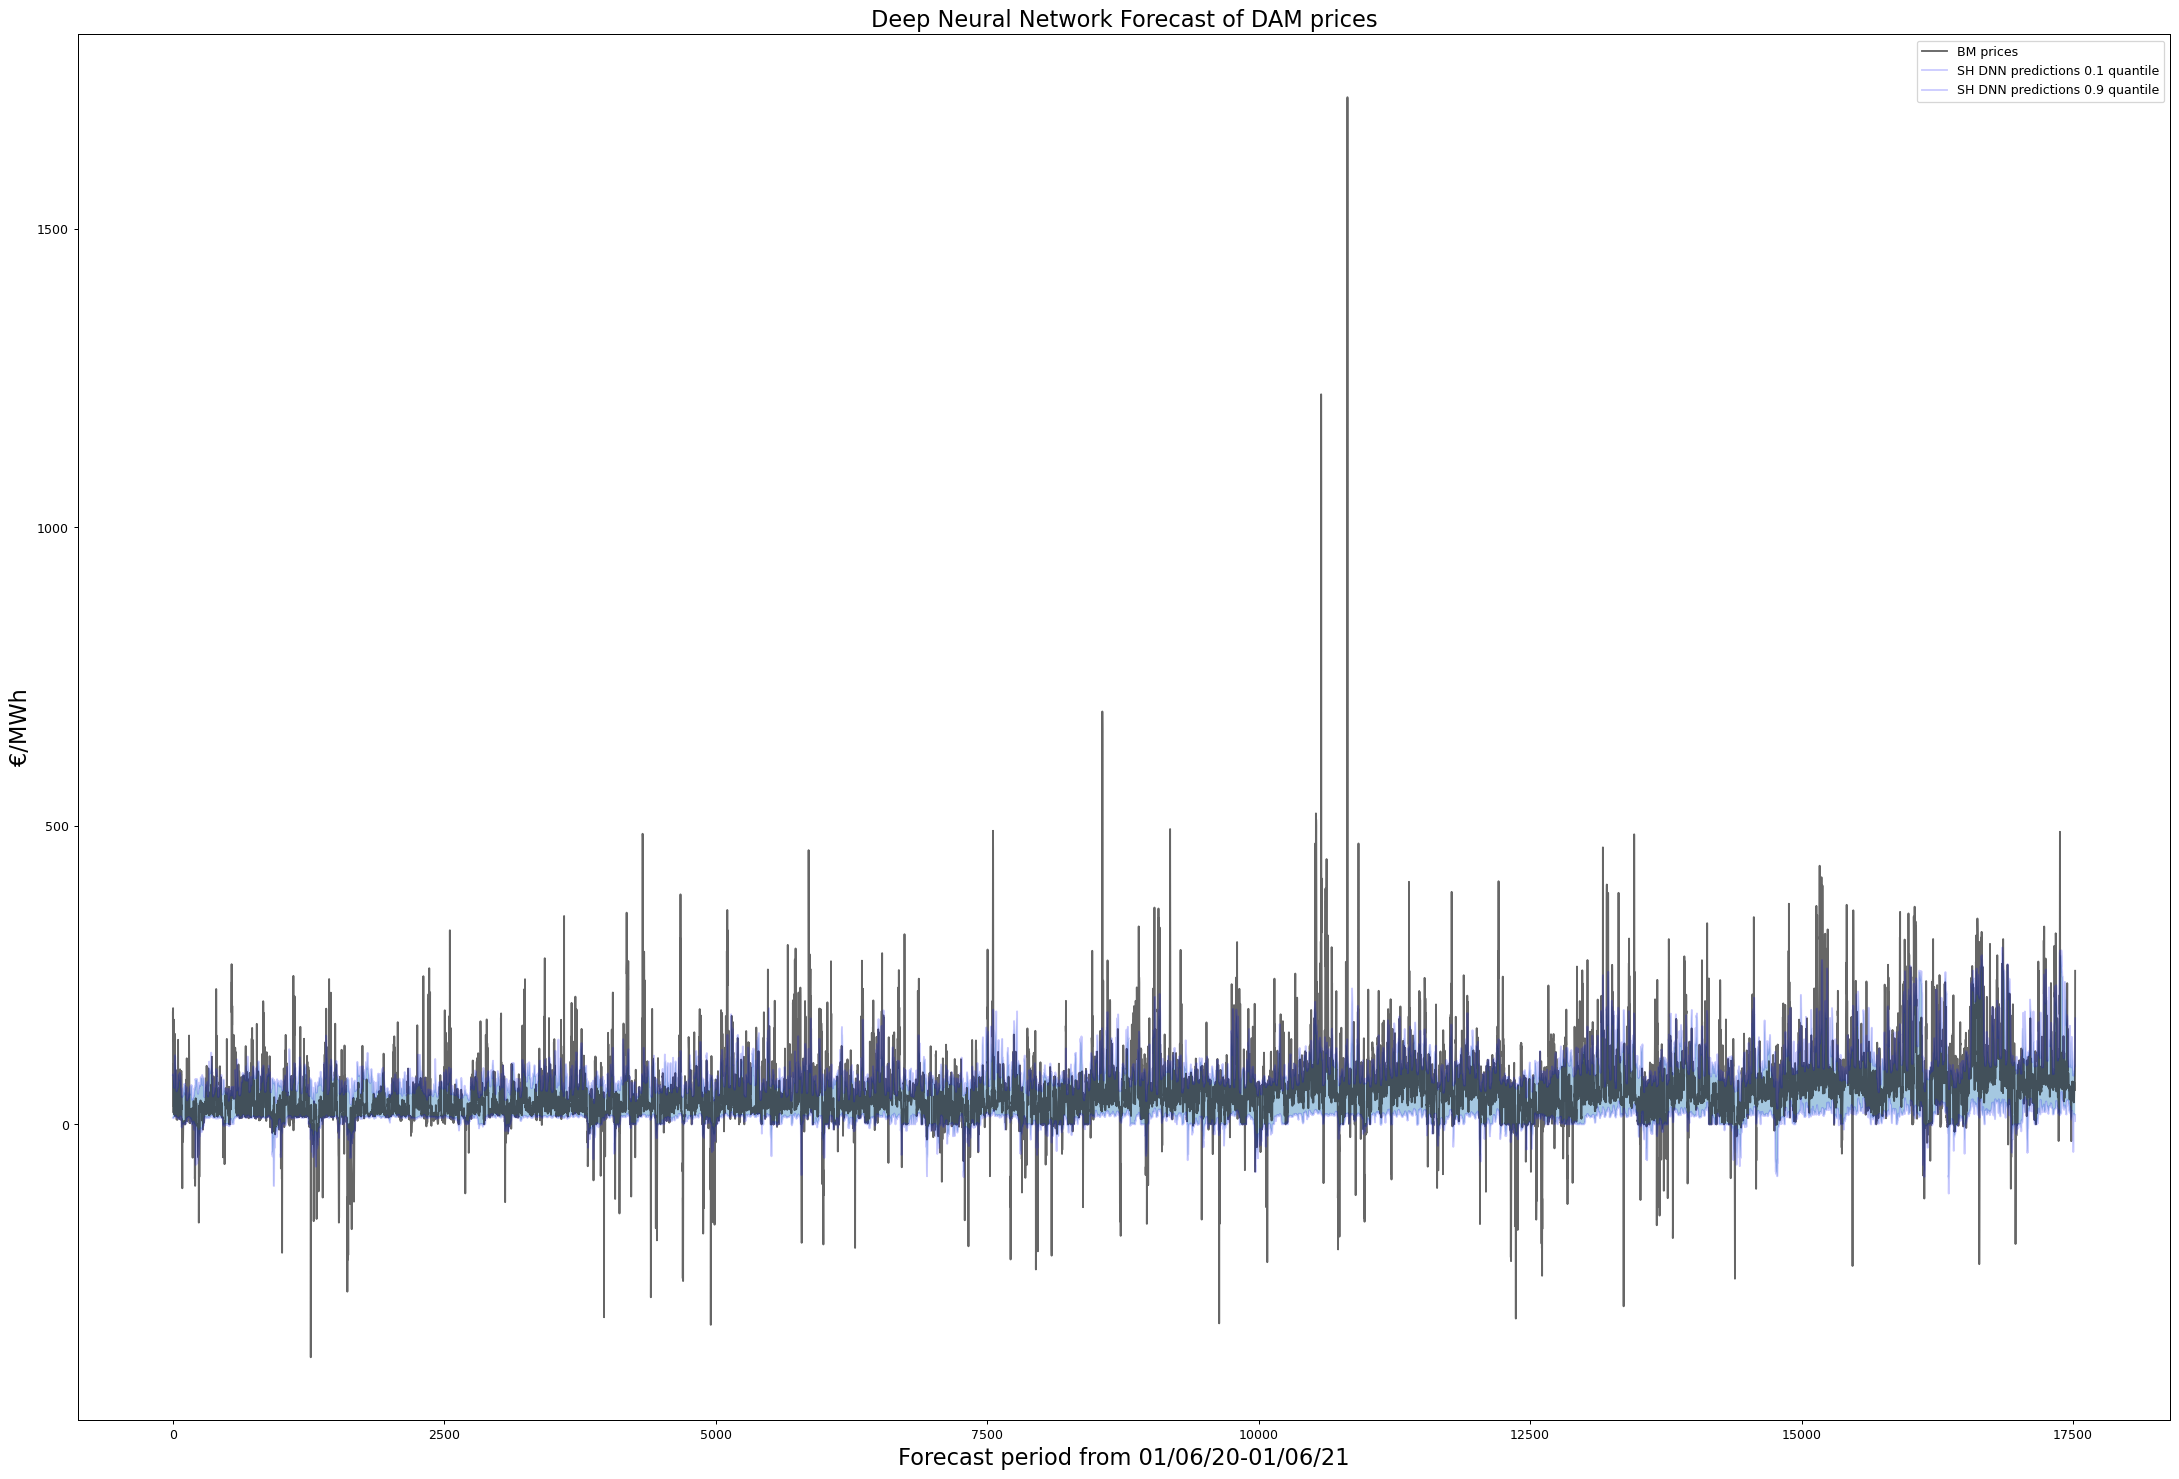

In [3]:
date_format="%m/%d/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/BM_QRA/Model_preds/knn_Q_1-12.csv")
dat1=dat1.iloc[456:,:].reset_index(drop=True)
dat1=pd.DataFrame(dat1)

column_names = ['lag_{}y_Forecast_10'.format(i) for i in range(2, 18)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_30'.format(i) for i in range(2, 18)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_50'.format(i) for i in range(2, 18)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_70'.format(i) for i in range(2, 18)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_90'.format(i) for i in range(2, 18)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y'.format(i) for i in range(2, 18)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

Performance Metrics for Quantile RMSE:
RMSE: 84.47
RMSE: 74.37
RMSE: 64.63
RMSE: 65.24
RMSE: 100.57
RMSE: 77.86

Performance Metrics for Quantile MAE:
MAE: 60.95
MAE: 48.52
MAE: 37.14
MAE: 45.99
MAE: 83.78
MAE: 55.28

Performance Metrics for Quantile Pinball Score:
Pinball Score: 7.73
Pinball Score: 15.73
Pinball Score: 18.57
Pinball Score: 18.44
Pinball Score: 12.53
Pinball Score: 14.60

Performance Metrics for Quantile sMAPE:
sMAPE: 160.70
sMAPE: 121.55
sMAPE: nan
sMAPE: 74.93
sMAPE: 97.64
sMAPE: 113.71

Performance Metrics for Quantile Winkler Score:
Winkler Score: 131.93
Winkler Score: 116.15
Winkler Score: 148.54
Winkler Score: 399.92
Winkler Score: 343.76
Winkler Score: 132.21

Performance Metrics for Quantile Mean Width:
Mean Width: 130.28
Mean Width: 65.45
Mean Width: 0.00
Mean Width: 65.45
Mean Width: 130.28
Mean Width: 97.86

Performance Metrics for Quantile coverage:
coverage: 0.86
coverage: 0.65
coverage: 0.64
coverage: 0.00
coverage: 0.00
coverage: 0.72

Total hours that r

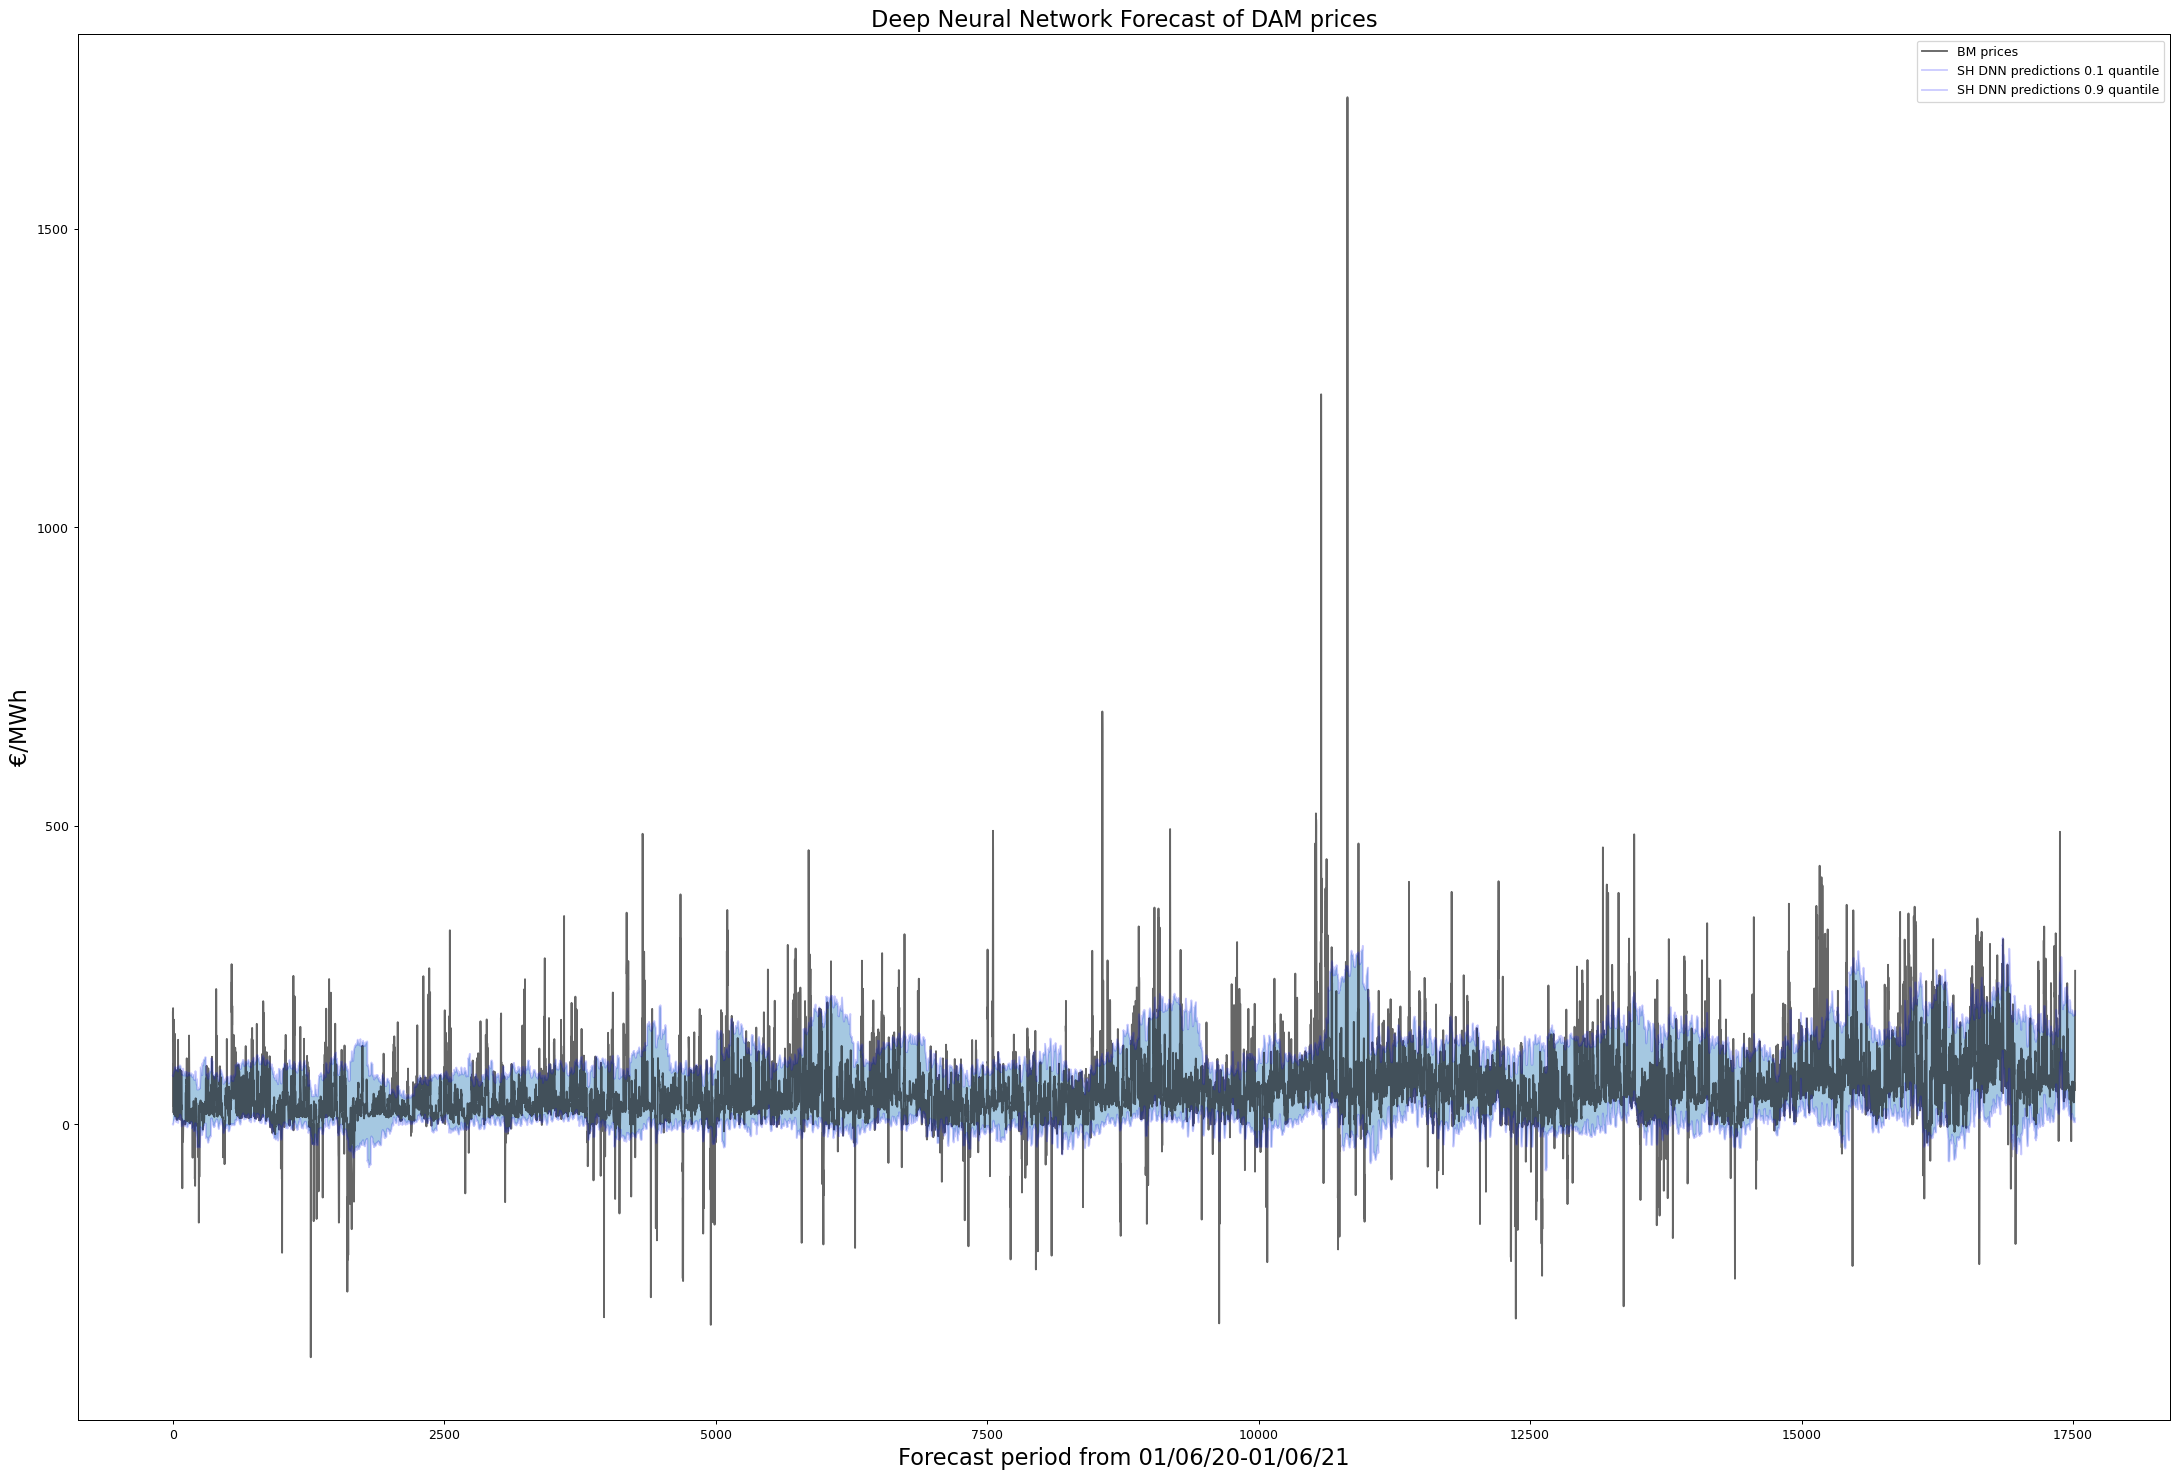

In [4]:
date_format="%m/%d/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/BM_QRA/Model_preds/knn_EnbPI_BM_1-12.csv")
dat1=dat1.iloc[456:,:].reset_index(drop=True)
dat1=pd.DataFrame(dat1)


column_names = ['lag_{}y_Forecast_10'.format(i) for i in range(2, 18)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_30'.format(i) for i in range(2, 18)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_50'.format(i) for i in range(2, 18)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_70'.format(i) for i in range(2, 18)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_90'.format(i) for i in range(2, 18)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y'.format(i) for i in range(2, 18)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

Performance Metrics for Quantile RMSE:
RMSE: 86.71
RMSE: 79.13
RMSE: 64.63
RMSE: 73.36
RMSE: 97.97
RMSE: 80.36

Performance Metrics for Quantile MAE:
MAE: 60.13
MAE: 51.73
MAE: 37.14
MAE: 44.33
MAE: 65.08
MAE: 51.68

Performance Metrics for Quantile Pinball Score:
Pinball Score: 8.26
Pinball Score: 16.90
Pinball Score: 18.57
Pinball Score: 20.30
Pinball Score: 15.21
Pinball Score: 15.85

Performance Metrics for Quantile sMAPE:
sMAPE: 146.58
sMAPE: 125.70
sMAPE: nan
sMAPE: 74.00
sMAPE: 86.09
sMAPE: 108.09

Performance Metrics for Quantile Winkler Score:
Winkler Score: 108.26
Winkler Score: 135.43
Winkler Score: 148.54
Winkler Score: 375.56
Winkler Score: 278.81
Winkler Score: 130.74

Performance Metrics for Quantile Mean Width:
Mean Width: 97.84
Mean Width: 54.16
Mean Width: 0.00
Mean Width: 54.16
Mean Width: 97.84
Mean Width: 76.00

Performance Metrics for Quantile coverage:
coverage: 0.71
coverage: 0.52
coverage: 0.64
coverage: 0.00
coverage: 0.00
coverage: 0.62

Total hours that reje

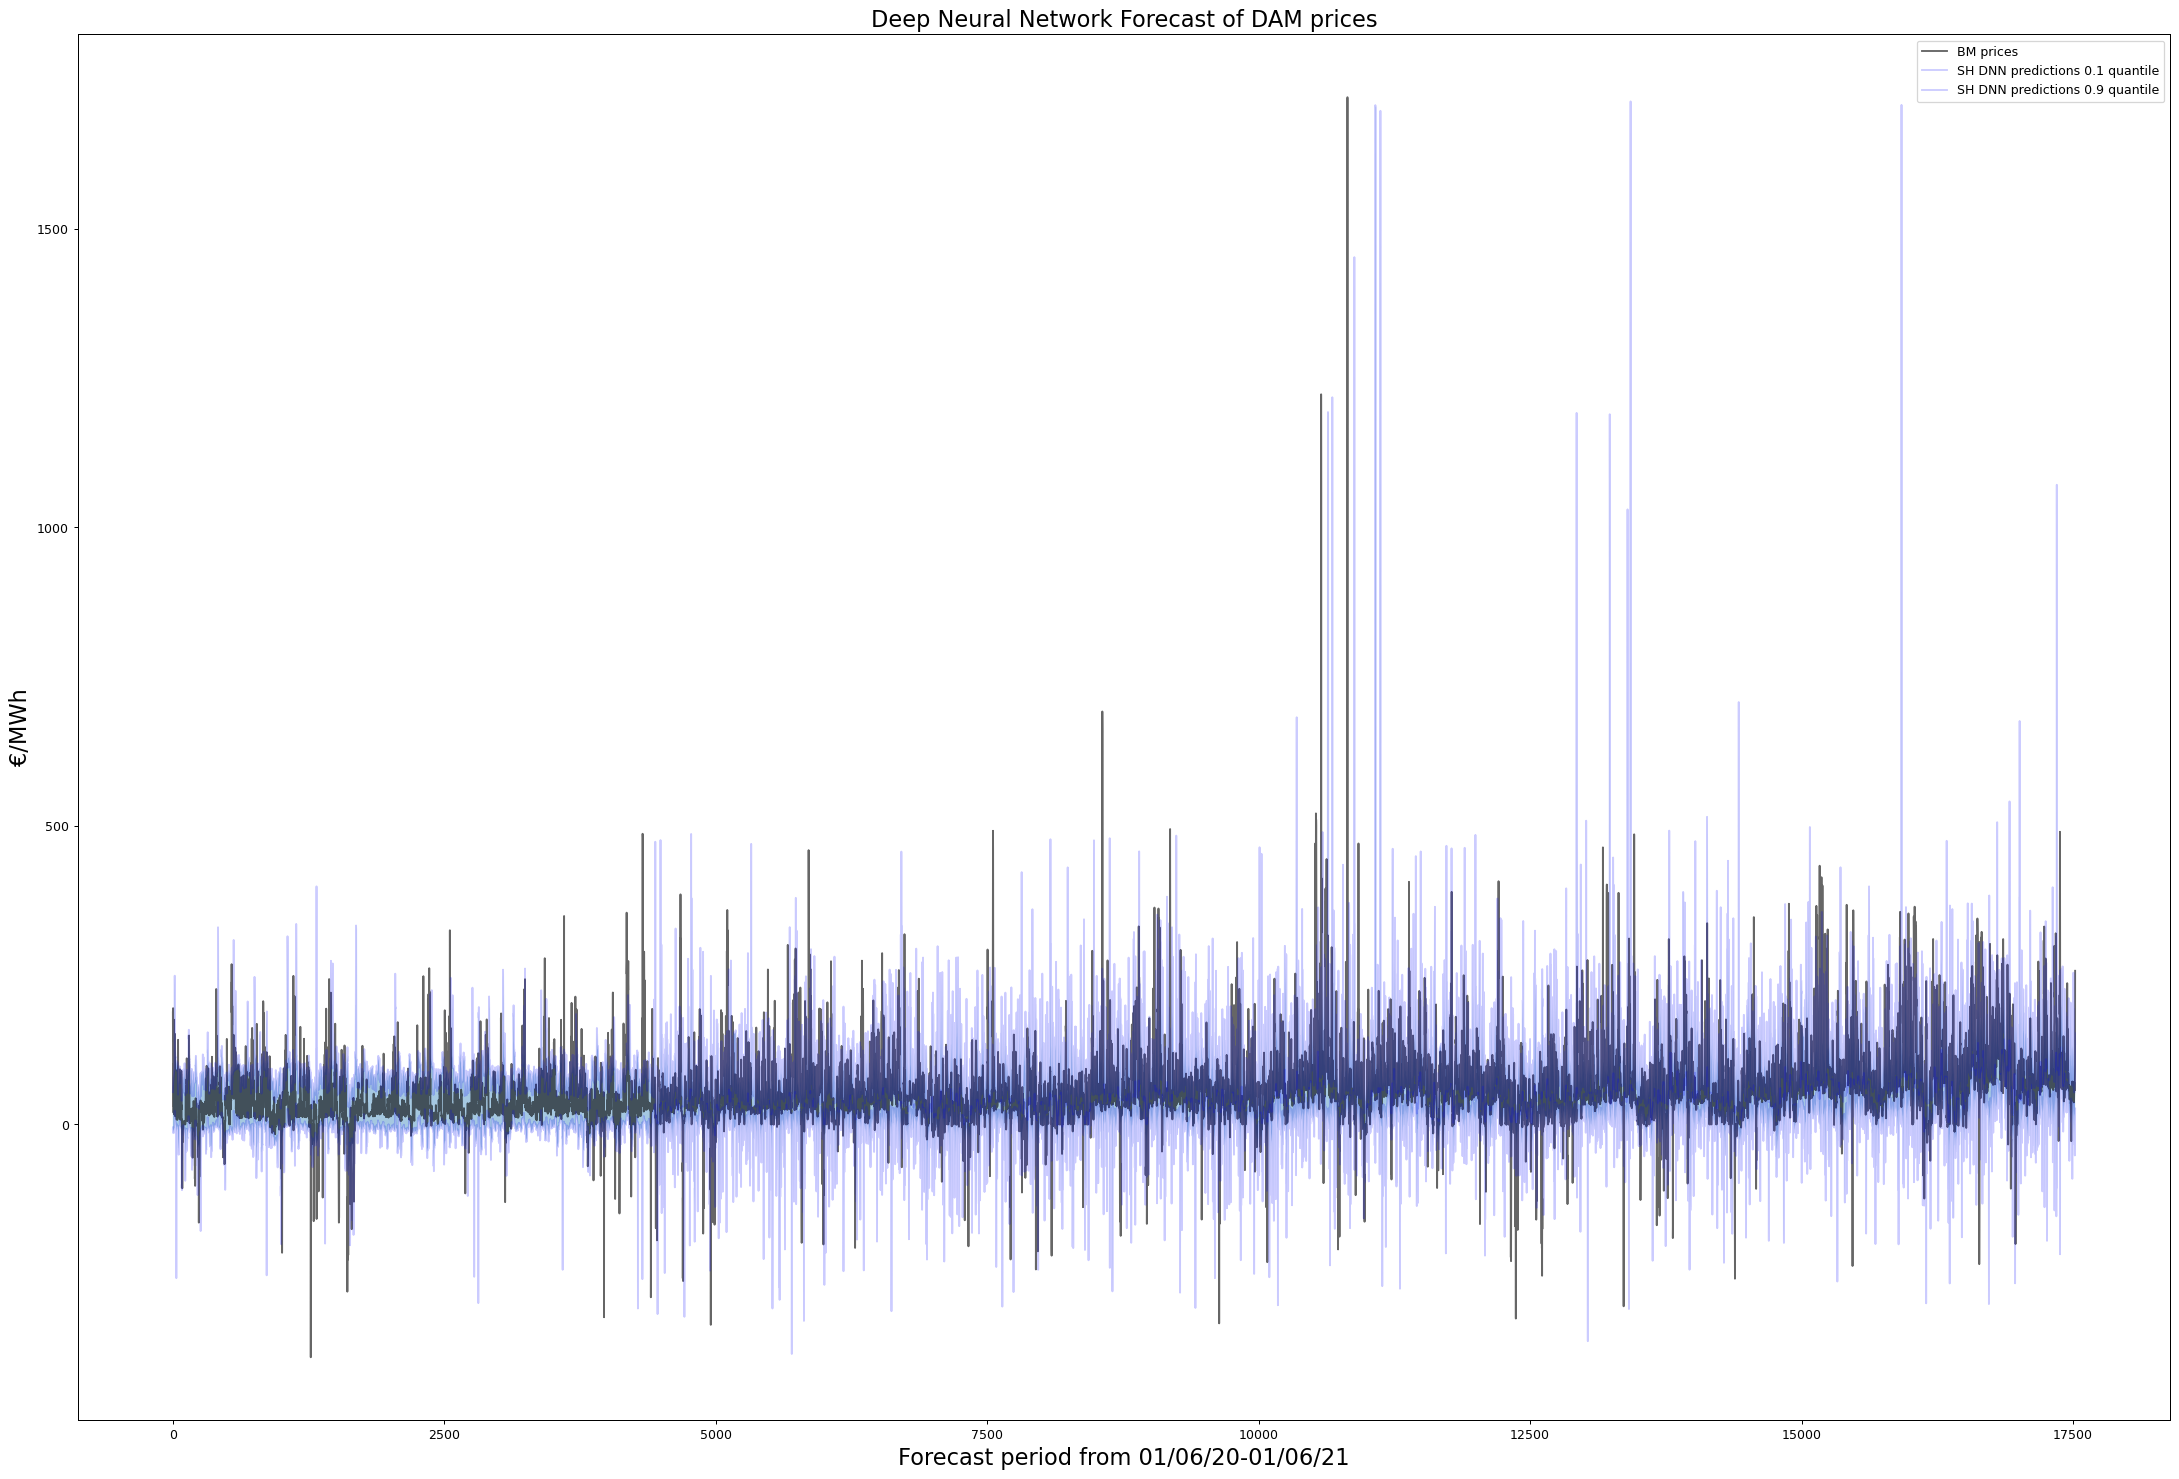

In [5]:
date_format="%m/%d/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/BM_QRA/Model_preds/knn_SPCI_BM_1-12.csv")
dat1=dat1.iloc[456:,:].reset_index(drop=True)
dat1=pd.DataFrame(dat1)


column_names = ['lag_{}y_Forecast_10'.format(i) for i in range(2, 18)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_30'.format(i) for i in range(2, 18)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_50'.format(i) for i in range(2, 18)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_70'.format(i) for i in range(2, 18)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_90'.format(i) for i in range(2, 18)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y'.format(i) for i in range(2, 18)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95 
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

Performance Metrics for Quantile RMSE:
RMSE: 78.75
RMSE: 70.97
RMSE: 64.18
RMSE: 59.30
RMSE: 71.11
RMSE: 68.86

Performance Metrics for Quantile MAE:
MAE: 52.66
MAE: 42.91
MAE: 36.83
MAE: 35.99
MAE: 53.61
MAE: 44.40

Performance Metrics for Quantile Pinball Score:
Pinball Score: 7.05
Pinball Score: 14.37
Pinball Score: 18.41
Pinball Score: 18.42
Pinball Score: 11.78
Pinball Score: 14.01

Performance Metrics for Quantile sMAPE:
sMAPE: nan
sMAPE: nan
sMAPE: nan
sMAPE: 67.36
sMAPE: 80.96
sMAPE: 74.16

Performance Metrics for Quantile Winkler Score:
Winkler Score: 91.56
Winkler Score: 127.58
Winkler Score: 147.31
Winkler Score: 280.53
Winkler Score: 240.03
Winkler Score: 122.15

Performance Metrics for Quantile Mean Width:
Mean Width: 85.75
Mean Width: 33.31
Mean Width: 0.00
Mean Width: 33.31
Mean Width: 85.75
Mean Width: 59.53

Performance Metrics for Quantile coverage:
coverage: 0.76
coverage: 0.40
coverage: 0.62
coverage: 0.00
coverage: 0.00
coverage: 0.59

Total hours that reject the n

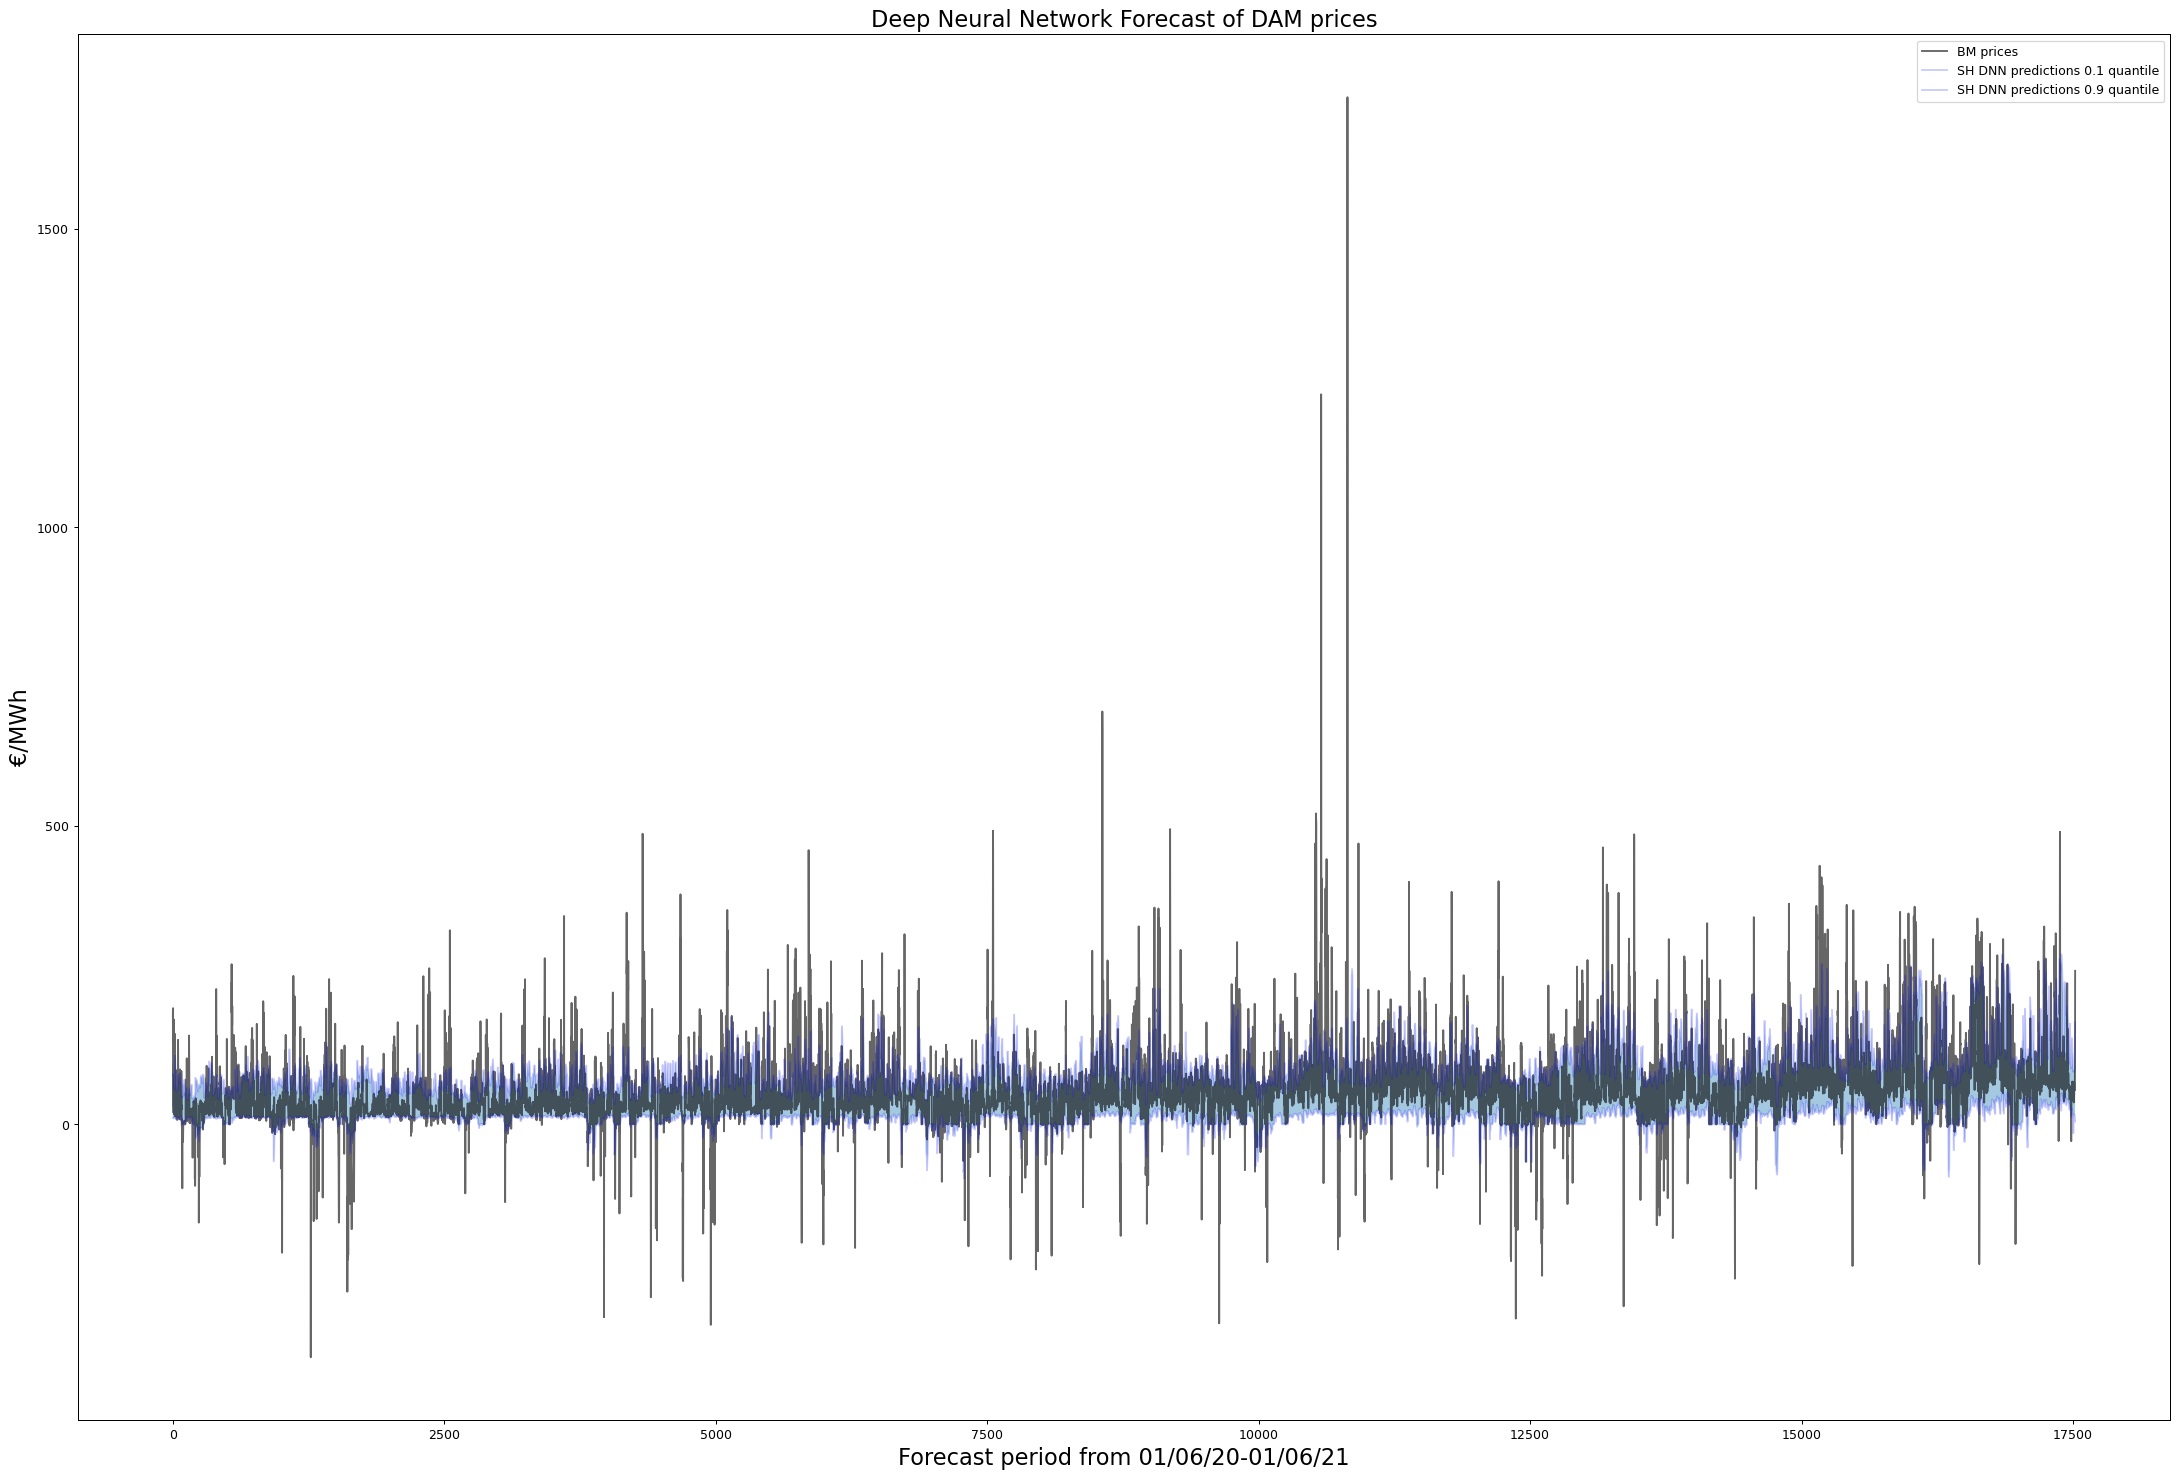

In [6]:
date_format="%m/%d/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/BM_QRA/Subset_QRA/knn_Q_QRA_1-12.csv")
dat1=dat1.iloc[363:,:].reset_index(drop=True)
dat1=pd.DataFrame(dat1)

column_names = ['lag_{}y_Forecast_10'.format(i) for i in range(2, 18)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_30'.format(i) for i in range(2, 18)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_50'.format(i) for i in range(2, 18)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_70'.format(i) for i in range(2, 18)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_90'.format(i) for i in range(2, 18)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y'.format(i) for i in range(2, 18)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

Performance Metrics for Quantile RMSE:
RMSE: 86.89
RMSE: 75.96
RMSE: 53.92
RMSE: 64.93
RMSE: 70.77
RMSE: 70.49

Performance Metrics for Quantile MAE:
MAE: 61.30
MAE: 48.06
MAE: 33.66
MAE: 38.55
MAE: 53.03
MAE: 46.92

Performance Metrics for Quantile Pinball Score:
Pinball Score: 7.96
Pinball Score: 16.26
Pinball Score: 16.83
Pinball Score: 20.96
Pinball Score: 14.12
Pinball Score: 15.22

Performance Metrics for Quantile sMAPE:
sMAPE: nan
sMAPE: 102.25
sMAPE: 66.41
sMAPE: 69.16
sMAPE: 80.92
sMAPE: 79.69

Performance Metrics for Quantile Winkler Score:
Winkler Score: 98.11
Winkler Score: 150.84
Winkler Score: 134.62
Winkler Score: 292.71
Winkler Score: 252.54
Winkler Score: 127.86

Performance Metrics for Quantile Mean Width:
Mean Width: 87.70
Mean Width: 30.47
Mean Width: 0.00
Mean Width: 30.47
Mean Width: 87.70
Mean Width: 59.09

Performance Metrics for Quantile coverage:
coverage: 0.75
coverage: 0.35
coverage: 0.44
coverage: 0.00
coverage: 0.00
coverage: 0.51

Total hours that reject 

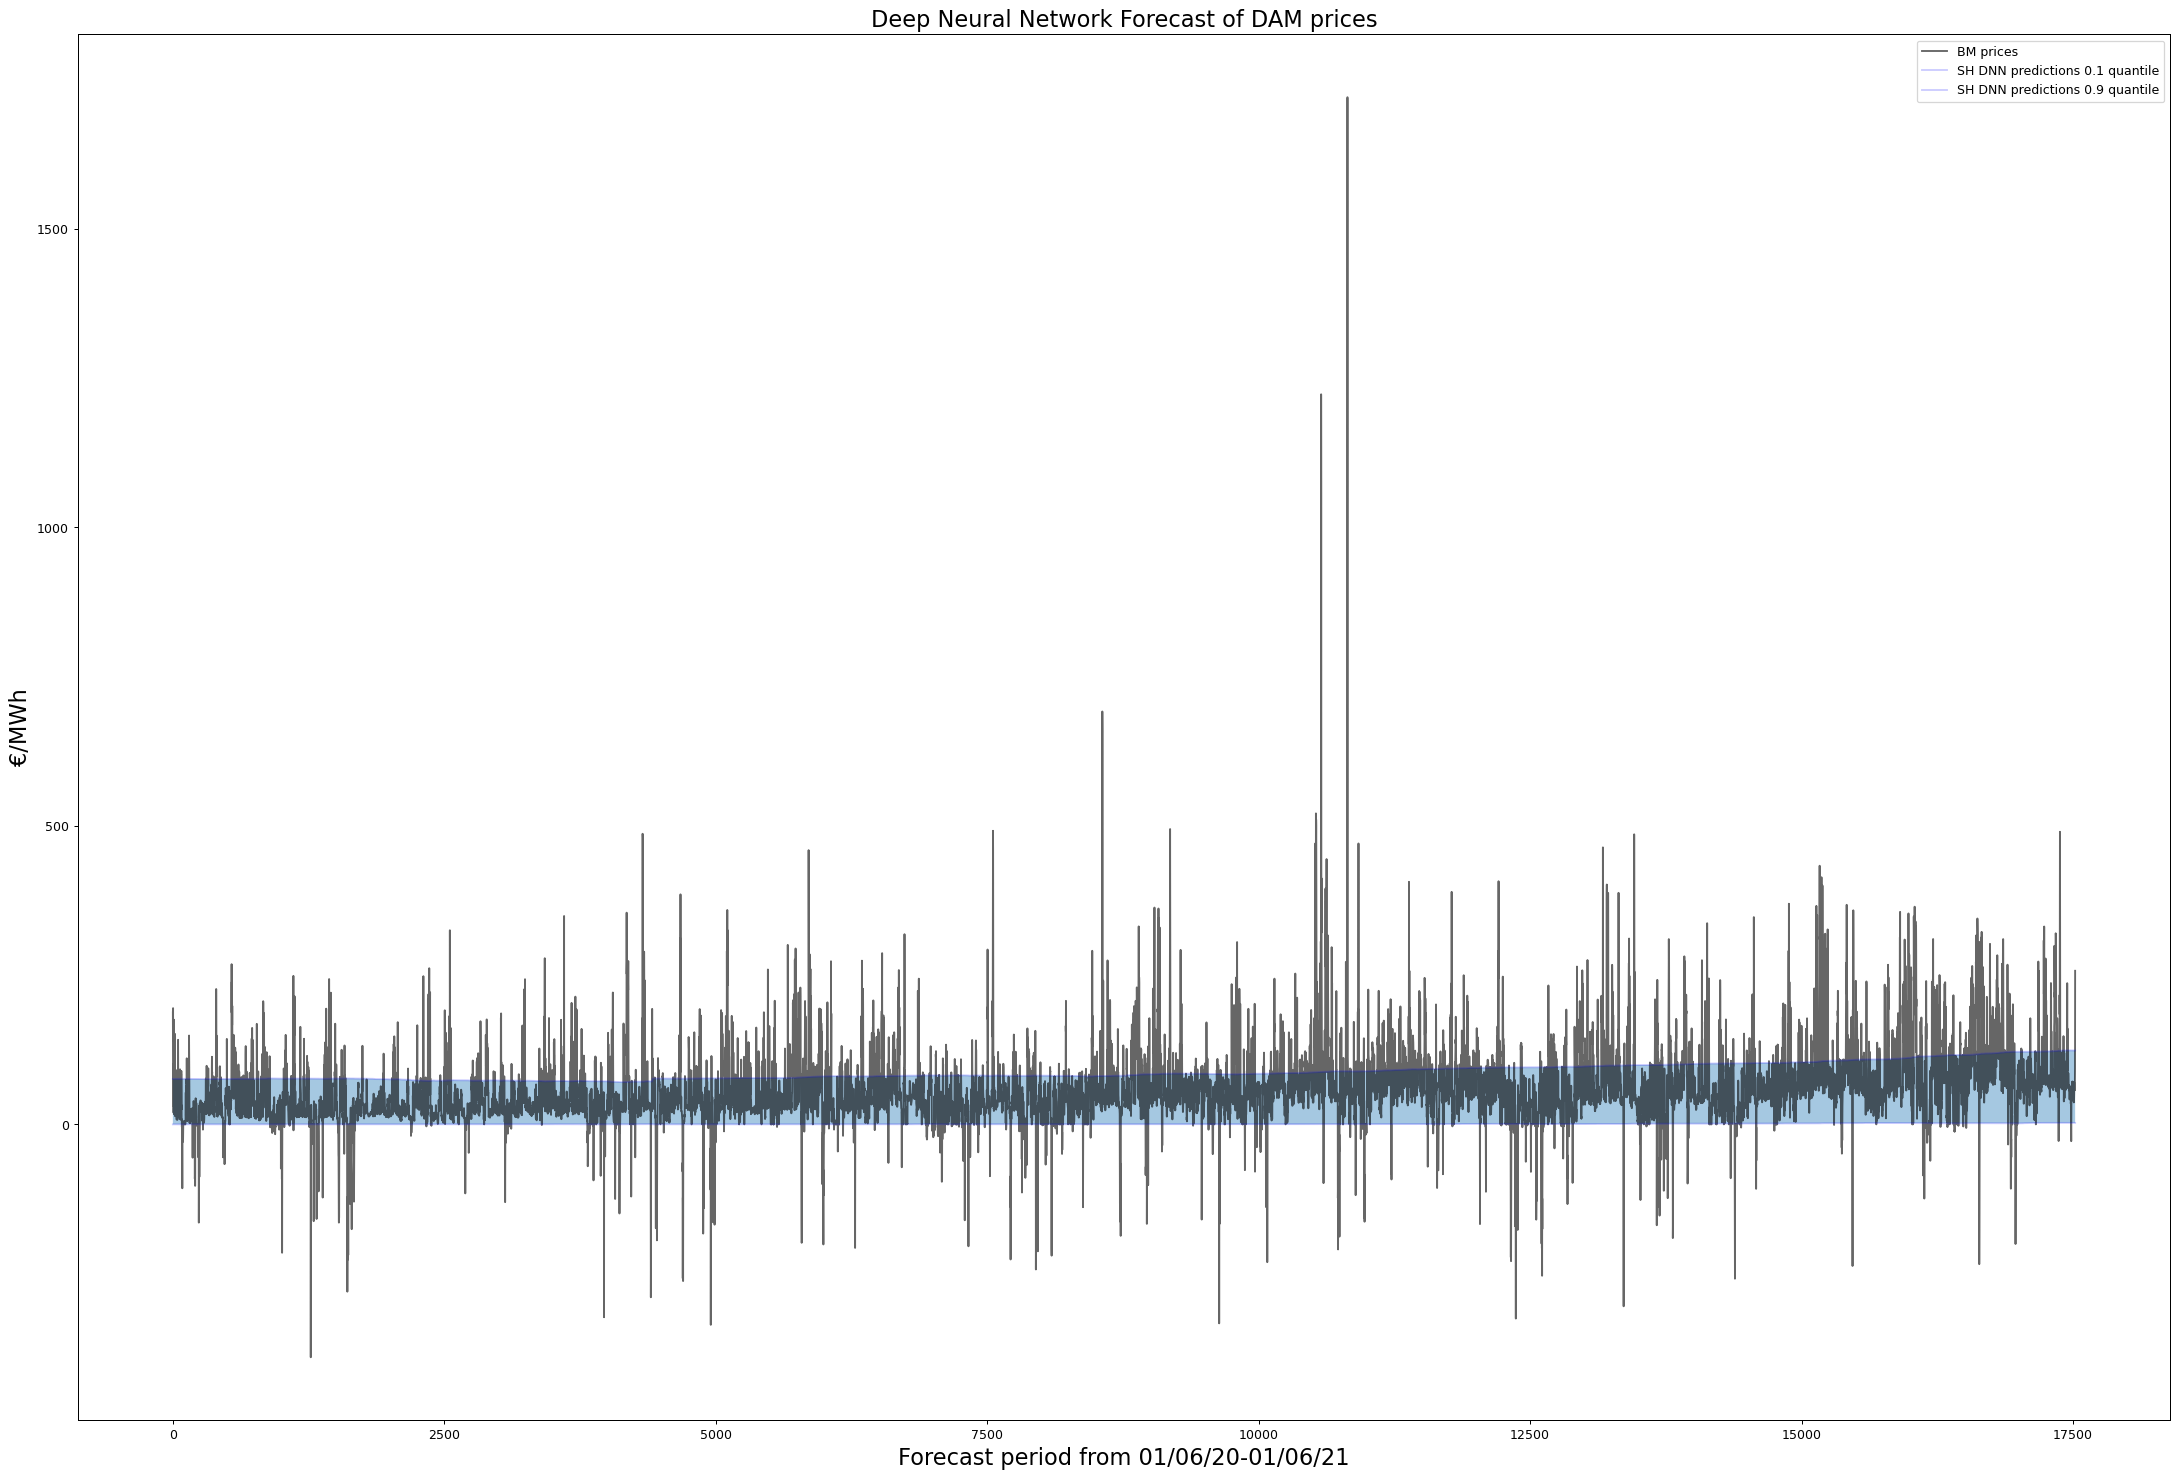

In [7]:
date_format="%m/%d/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/BM_QRA/Model_preds/Lasso_Q_1-12.csv")
dat1=dat1.iloc[456:,:].reset_index(drop=True)
dat1=pd.DataFrame(dat1)

column_names = ['lag_{}y_Forecast_10'.format(i) for i in range(2, 18)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_30'.format(i) for i in range(2, 18)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_50'.format(i) for i in range(2, 18)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_70'.format(i) for i in range(2, 18)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_90'.format(i) for i in range(2, 18)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y'.format(i) for i in range(2, 18)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

Performance Metrics for Quantile RMSE:
RMSE: 71.78
RMSE: 62.85
RMSE: 56.67
RMSE: 56.79
RMSE: 73.16
RMSE: 64.25

Performance Metrics for Quantile MAE:
MAE: 45.21
MAE: 35.91
MAE: 32.98
MAE: 37.03
MAE: 55.41
MAE: 41.31

Performance Metrics for Quantile Pinball Score:
Pinball Score: 6.56
Pinball Score: 13.03
Pinball Score: 16.49
Pinball Score: 16.20
Pinball Score: 10.15
Pinball Score: 12.48

Performance Metrics for Quantile sMAPE:
sMAPE: 103.15
sMAPE: 74.56
sMAPE: 65.50
sMAPE: 68.05
sMAPE: 81.95
sMAPE: 78.64

Performance Metrics for Quantile Winkler Score:
Winkler Score: 84.31
Winkler Score: 105.88
Winkler Score: 131.90
Winkler Score: 272.84
Winkler Score: 230.79
Winkler Score: 107.36

Performance Metrics for Quantile Mean Width:
Mean Width: 84.01
Mean Width: 36.22
Mean Width: 0.00
Mean Width: 36.22
Mean Width: 84.01
Mean Width: 60.11

Performance Metrics for Quantile coverage:
coverage: 0.75
coverage: 0.37
coverage: 0.50
coverage: 0.00
coverage: 0.00
coverage: 0.54

Total hours that rejec

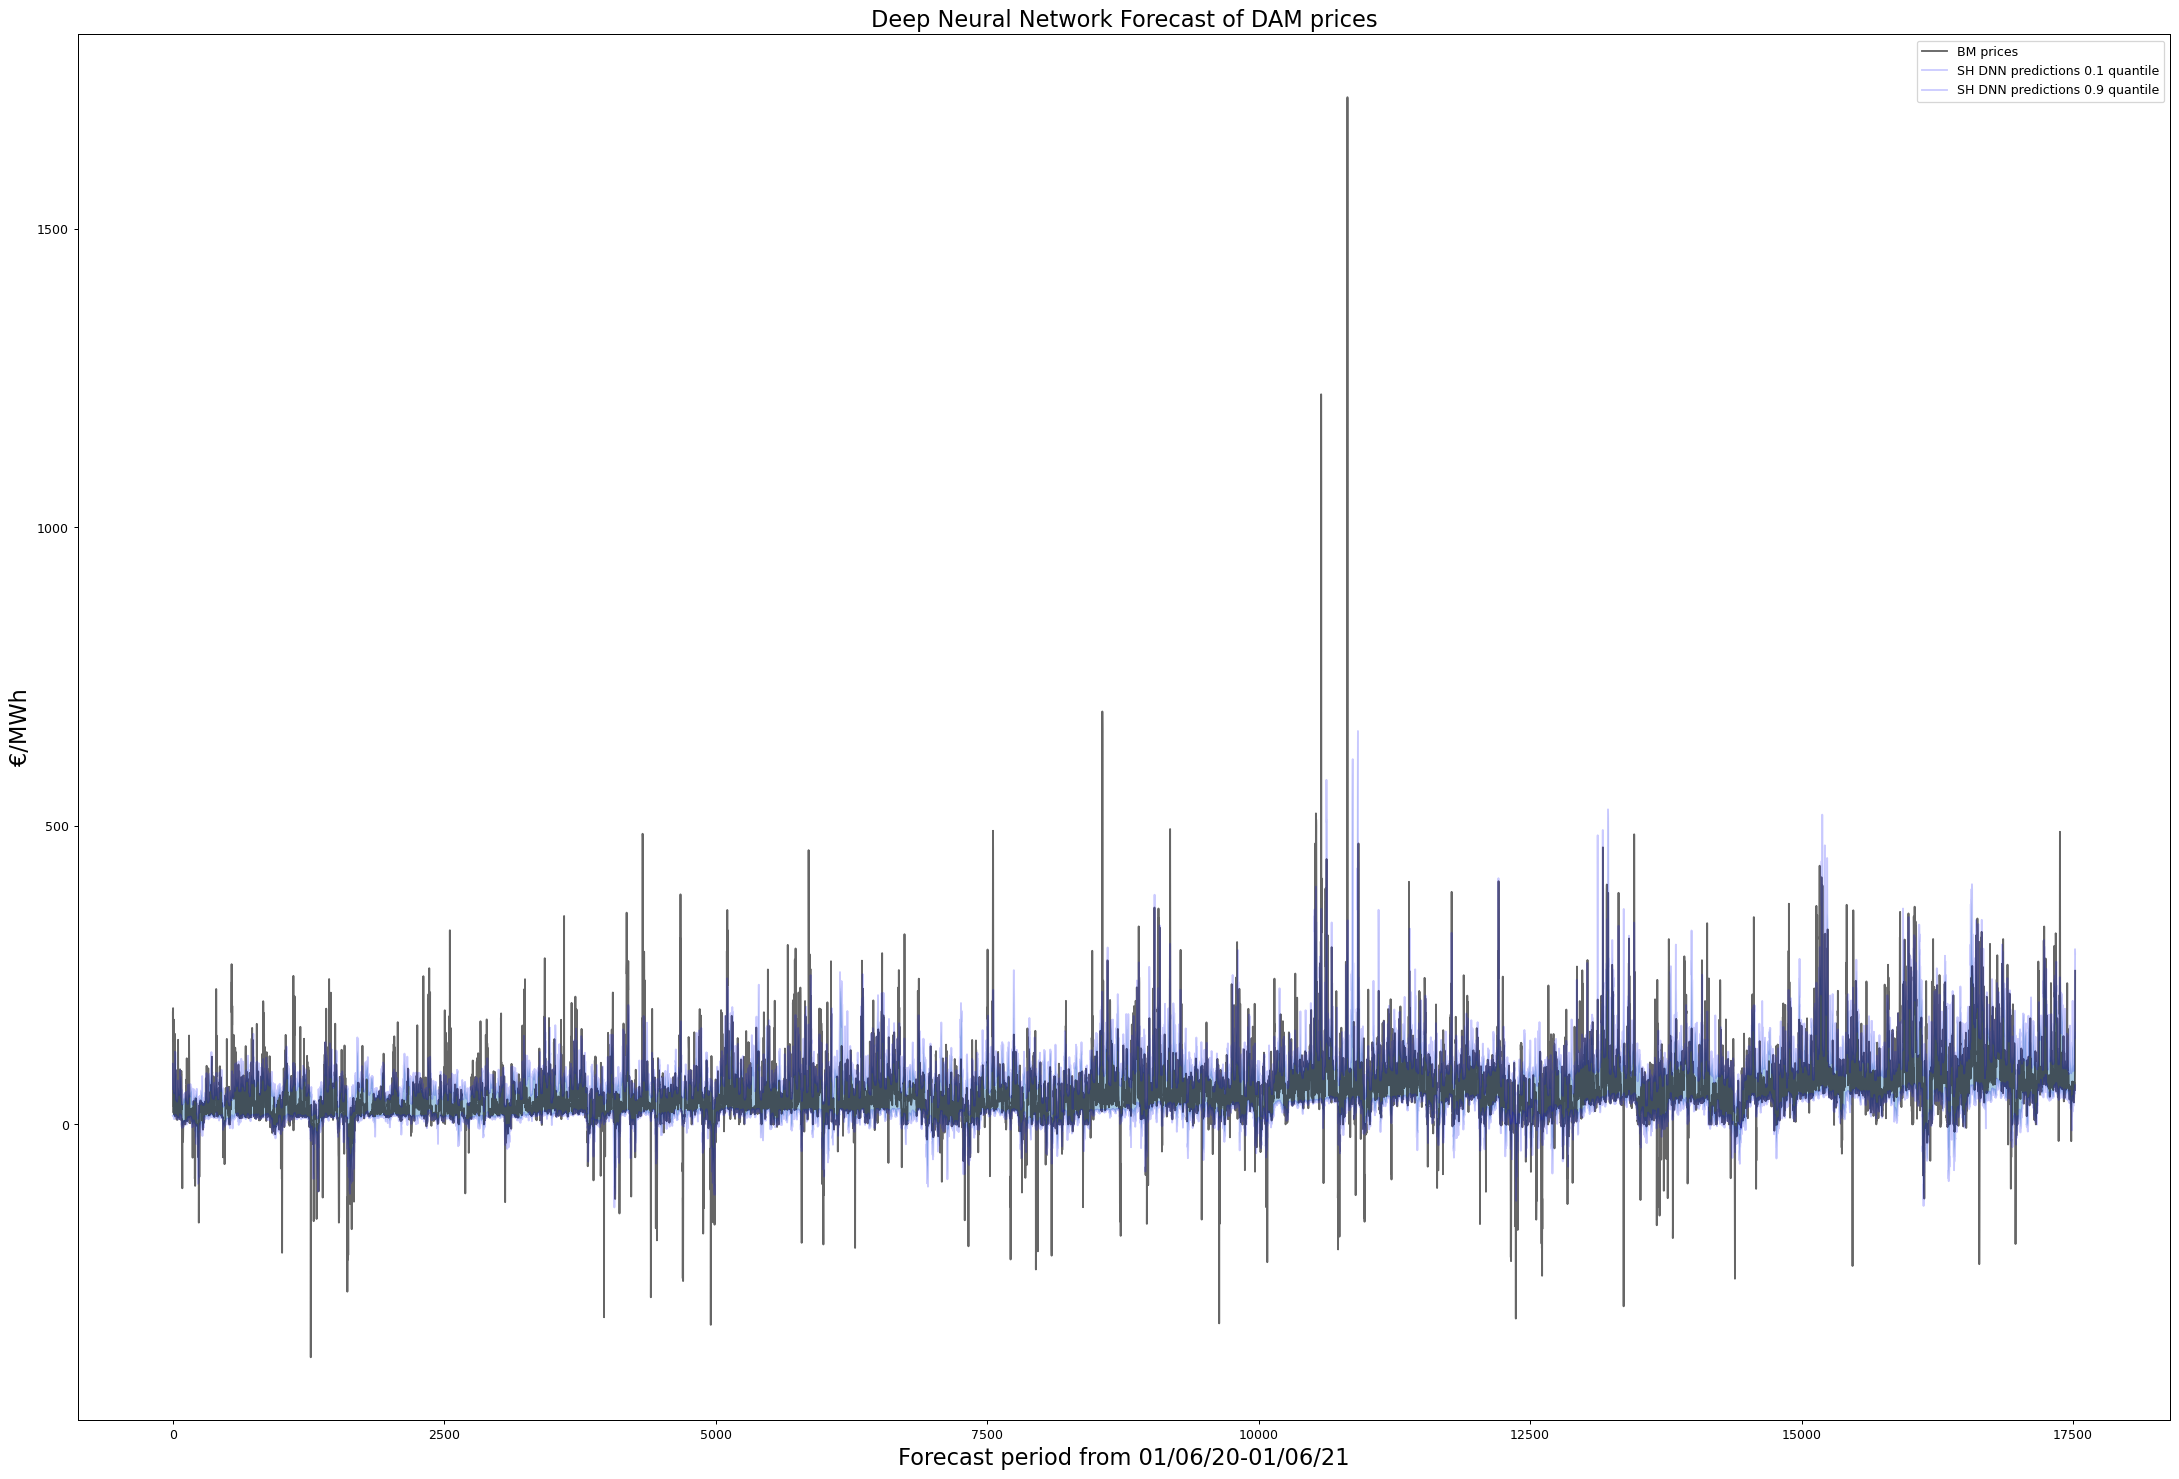

In [8]:
date_format="%m/%d/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/BM_QRA/Model_preds/lgbm_Q_1-12.csv")
dat1=dat1.iloc[456:,:].reset_index(drop=True)


column_names = ['lag_{}y_Forecast_10'.format(i) for i in range(2, 18)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_30'.format(i) for i in range(2, 18)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_50'.format(i) for i in range(2, 18)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_70'.format(i) for i in range(2, 18)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_90'.format(i) for i in range(2, 18)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y'.format(i) for i in range(2, 18)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

Performance Metrics for Quantile RMSE:
RMSE: 75.42
RMSE: 63.56
RMSE: 56.24
RMSE: 57.03
RMSE: 92.90
RMSE: 69.03

Performance Metrics for Quantile MAE:
MAE: 50.40
MAE: 37.69
MAE: 33.43
MAE: 37.45
MAE: 67.72
MAE: 45.34

Performance Metrics for Quantile Pinball Score:
Pinball Score: 6.88
Pinball Score: 13.39
Pinball Score: 16.71
Pinball Score: 16.24
Pinball Score: 10.10
Pinball Score: 12.66

Performance Metrics for Quantile sMAPE:
sMAPE: nan
sMAPE: nan
sMAPE: nan
sMAPE: nan
sMAPE: 89.11
sMAPE: 89.11

Performance Metrics for Quantile Winkler Score:
Winkler Score: 103.83
Winkler Score: 105.63
Winkler Score: 133.70
Winkler Score: 287.14
Winkler Score: 279.18
Winkler Score: 114.39

Performance Metrics for Quantile Mean Width:
Mean Width: 105.22
Mean Width: 39.71
Mean Width: 0.00
Mean Width: 39.71
Mean Width: 105.22
Mean Width: 72.47

Performance Metrics for Quantile coverage:
coverage: 0.82
coverage: 0.43
coverage: 0.52
coverage: 0.00
coverage: 0.00
coverage: 0.59

Total hours that reject the 

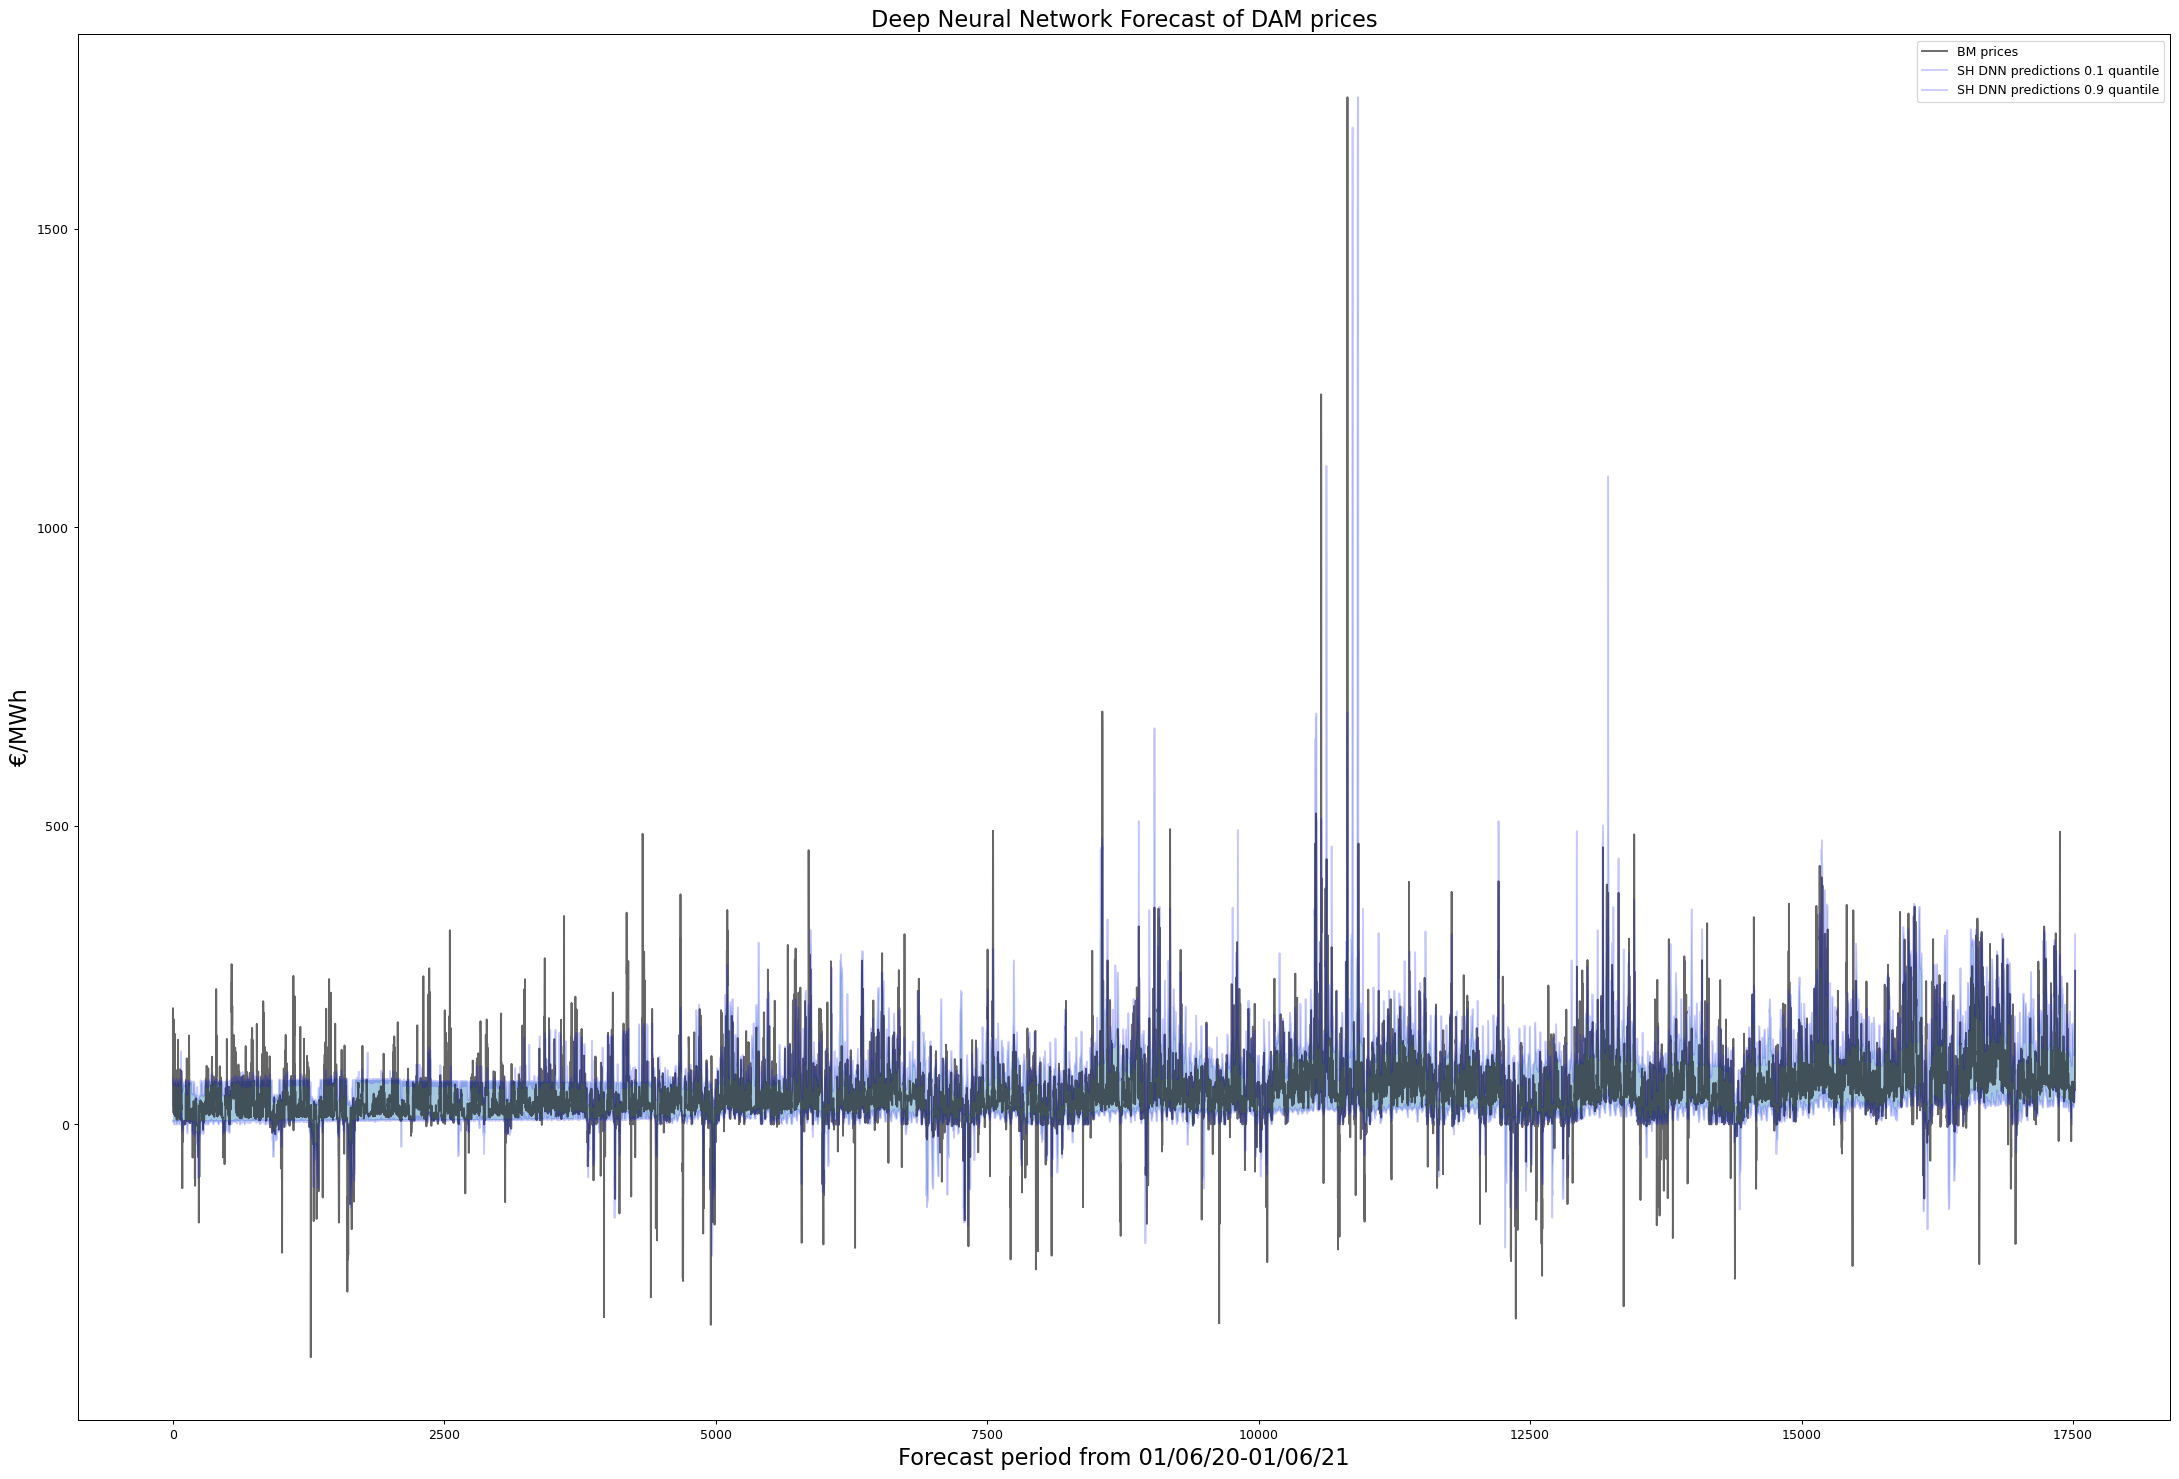

In [9]:
date_format="%m/%d/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/BM_QRA/Model_preds/rf_Q_1-12.csv")
dat1=dat1.iloc[456:,:].reset_index(drop=True)
dat1=pd.DataFrame(dat1)

column_names = ['lag_{}y_Forecast_10'.format(i) for i in range(2, 18)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_30'.format(i) for i in range(2, 18)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_50'.format(i) for i in range(2, 18)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_70'.format(i) for i in range(2, 18)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_90'.format(i) for i in range(2, 18)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y'.format(i) for i in range(2, 18)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

Performance Metrics for Quantile RMSE:
RMSE: 76.62
RMSE: 67.22
RMSE: 60.77
RMSE: 60.40
RMSE: 85.92
RMSE: 70.19

Performance Metrics for Quantile MAE:
MAE: 50.74
MAE: 40.02
MAE: 36.28
MAE: 39.52
MAE: 64.10
MAE: 46.13

Performance Metrics for Quantile Pinball Score:
Pinball Score: 7.03
Pinball Score: 14.16
Pinball Score: 18.14
Pinball Score: 17.96
Pinball Score: 11.43
Pinball Score: 13.74

Performance Metrics for Quantile sMAPE:
sMAPE: 122.59
sMAPE: 83.71
sMAPE: 70.30
sMAPE: 70.06
sMAPE: 85.64
sMAPE: 86.46

Performance Metrics for Quantile Winkler Score:
Winkler Score: 98.58
Winkler Score: 119.52
Winkler Score: 145.12
Winkler Score: 294.40
Winkler Score: 265.30
Winkler Score: 121.07

Performance Metrics for Quantile Mean Width:
Mean Width: 97.40
Mean Width: 38.22
Mean Width: 0.00
Mean Width: 38.22
Mean Width: 97.40
Mean Width: 67.81

Performance Metrics for Quantile coverage:
coverage: 0.76
coverage: 0.39
coverage: 0.54
coverage: 0.00
coverage: 0.00
coverage: 0.56

Total hours that rejec

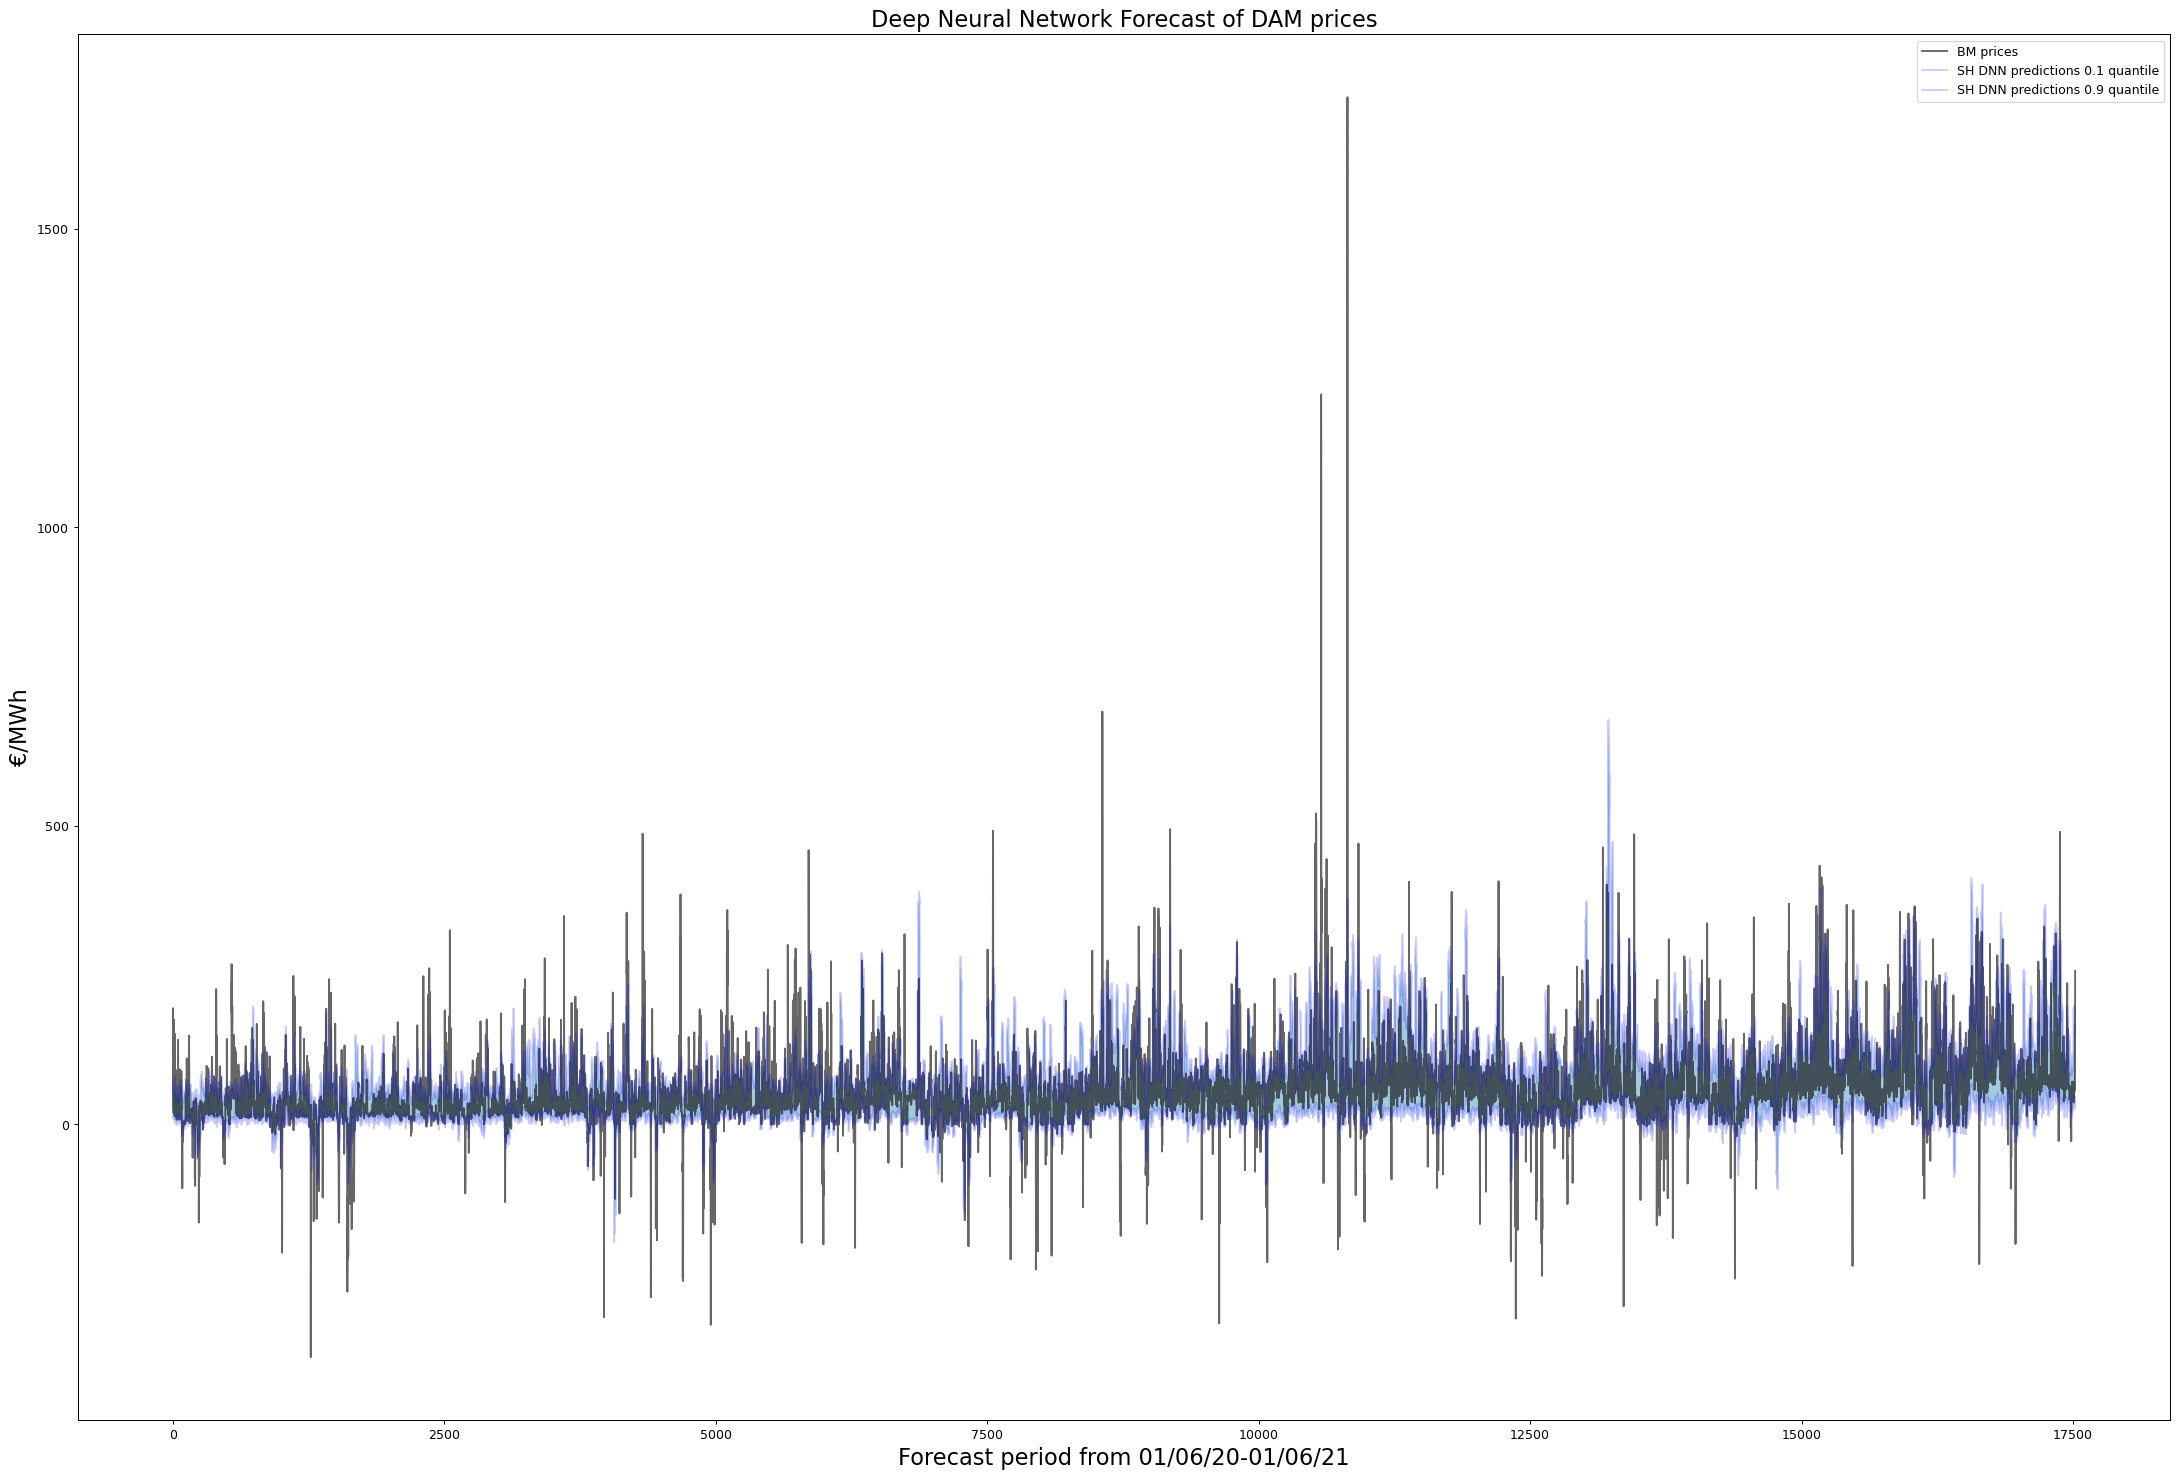

In [10]:
date_format="%m/%d/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/BM_QRA/Model_preds/SH_A_Q_1-12.csv")
dat1=dat1.iloc[456:,:].reset_index(drop=True)
dat1=pd.DataFrame(dat1)


column_names = ['lag_{}y_Forecast_10'.format(i) for i in range(2, 18)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_30'.format(i) for i in range(2, 18)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_50'.format(i) for i in range(2, 18)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_70'.format(i) for i in range(2, 18)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_90'.format(i) for i in range(2, 18)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y'.format(i) for i in range(2, 18)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

Performance Metrics for Quantile RMSE:
RMSE: 82.49
RMSE: 72.18
RMSE: 63.86
RMSE: 64.98
RMSE: 81.55
RMSE: 73.01

Performance Metrics for Quantile MAE:
MAE: 56.85
MAE: 44.74
MAE: 37.79
MAE: 39.48
MAE: 59.74
MAE: 47.72

Performance Metrics for Quantile Pinball Score:
Pinball Score: 7.60
Pinball Score: 15.46
Pinball Score: 18.90
Pinball Score: 21.19
Pinball Score: 13.34
Pinball Score: 15.30

Performance Metrics for Quantile sMAPE:
sMAPE: 146.82
sMAPE: 98.98
sMAPE: 74.29
sMAPE: 71.80
sMAPE: 83.51
sMAPE: 95.08

Performance Metrics for Quantile Winkler Score:
Winkler Score: 101.63
Winkler Score: 152.98
Winkler Score: 151.18
Winkler Score: 278.97
Winkler Score: 262.48
Winkler Score: 135.26

Performance Metrics for Quantile Mean Width:
Mean Width: 93.40
Mean Width: 28.59
Mean Width: 0.00
Mean Width: 28.59
Mean Width: 93.40
Mean Width: 60.99

Performance Metrics for Quantile coverage:
coverage: 0.73
coverage: 0.30
coverage: 0.59
coverage: 0.01
coverage: 0.00
coverage: 0.54

Total hours that reje

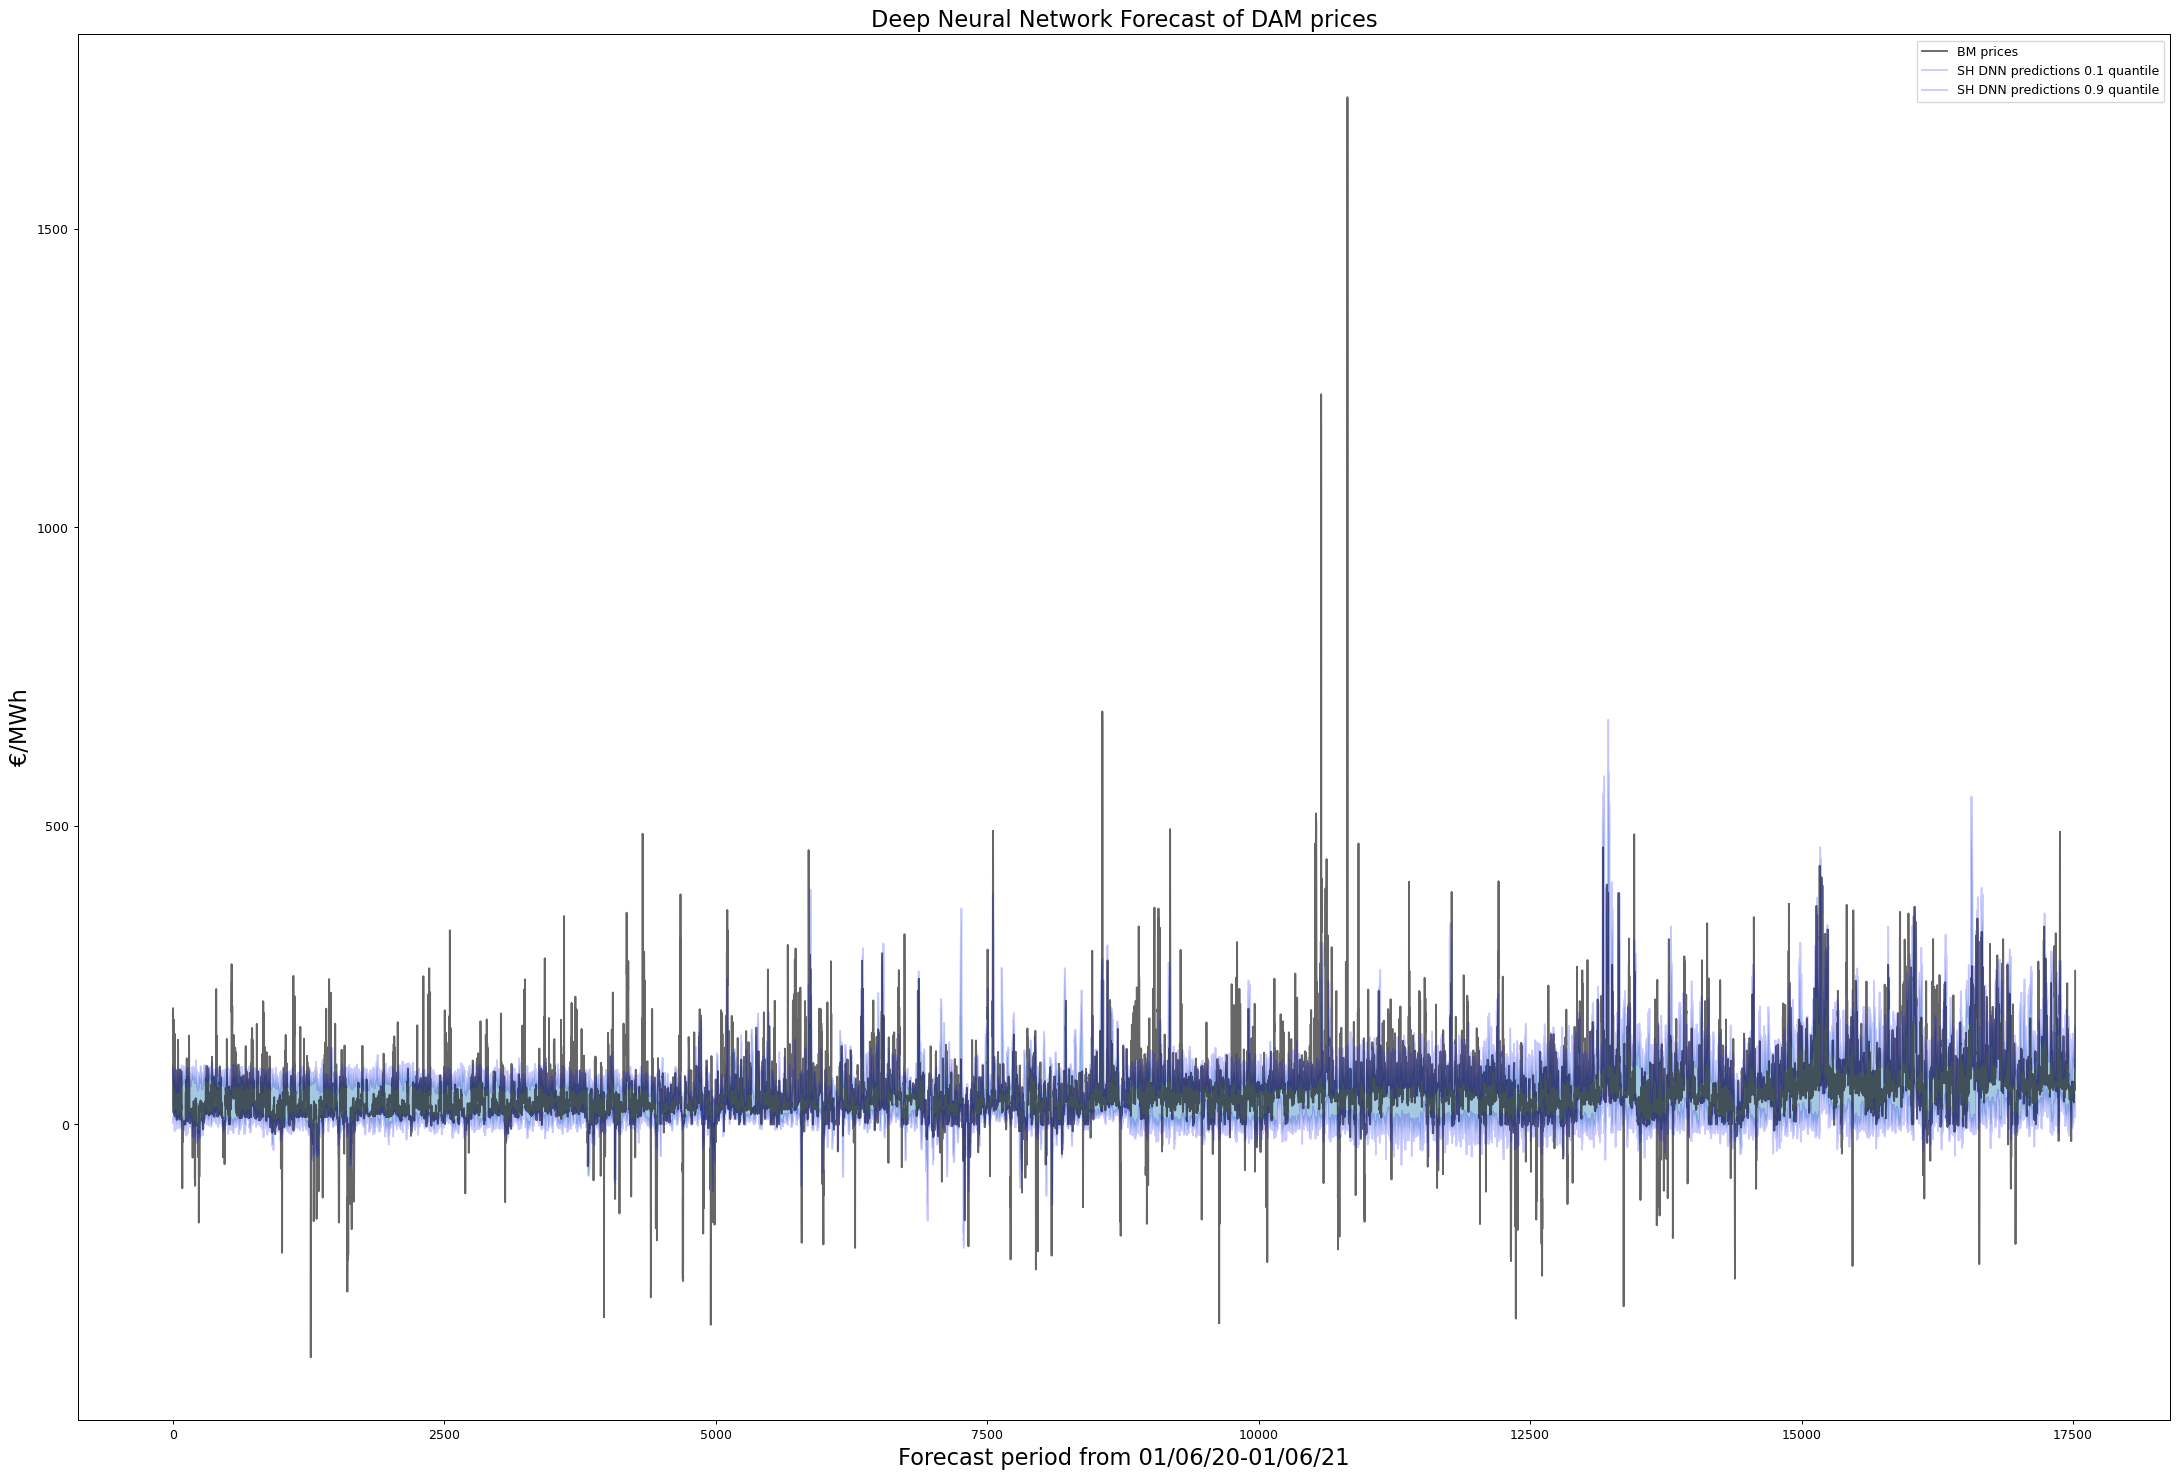

In [11]:
date_format="%m/%d/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/BM_QRA/Model_preds/SH_B_Q_1-12.csv")
dat1=dat1.iloc[456:,:].reset_index(drop=True)
dat1=pd.DataFrame(dat1)


column_names = ['lag_{}y_Forecast_10'.format(i) for i in range(2, 18)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_30'.format(i) for i in range(2, 18)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_50'.format(i) for i in range(2, 18)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_70'.format(i) for i in range(2, 18)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_90'.format(i) for i in range(2, 18)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y'.format(i) for i in range(2, 18)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

Performance Metrics for Quantile RMSE:
RMSE: 75.94
RMSE: 65.35
RMSE: 61.67
RMSE: 62.21
RMSE: 83.90
RMSE: 69.82

Performance Metrics for Quantile MAE:
MAE: 51.91
MAE: 41.67
MAE: 38.43
MAE: 41.35
MAE: 60.95
MAE: 46.86

Performance Metrics for Quantile Pinball Score:
Pinball Score: 7.21
Pinball Score: 14.66
Pinball Score: 19.22
Pinball Score: 20.30
Pinball Score: 16.79
Pinball Score: 15.64

Performance Metrics for Quantile sMAPE:
sMAPE: 139.05
sMAPE: 109.45
sMAPE: 98.13
sMAPE: 98.23
sMAPE: 109.97
sMAPE: 110.97

Performance Metrics for Quantile Winkler Score:
Winkler Score: 105.07
Winkler Score: 140.77
Winkler Score: 153.72
Winkler Score: 289.44
Winkler Score: 242.43
Winkler Score: 133.19

Performance Metrics for Quantile Mean Width:
Mean Width: 81.15
Mean Width: 33.34
Mean Width: 0.00
Mean Width: 33.34
Mean Width: 81.15
Mean Width: 57.25

Performance Metrics for Quantile coverage:
coverage: 0.59
coverage: 0.31
coverage: 0.63
coverage: 0.00
coverage: 0.00
coverage: 0.51

Total hours that r

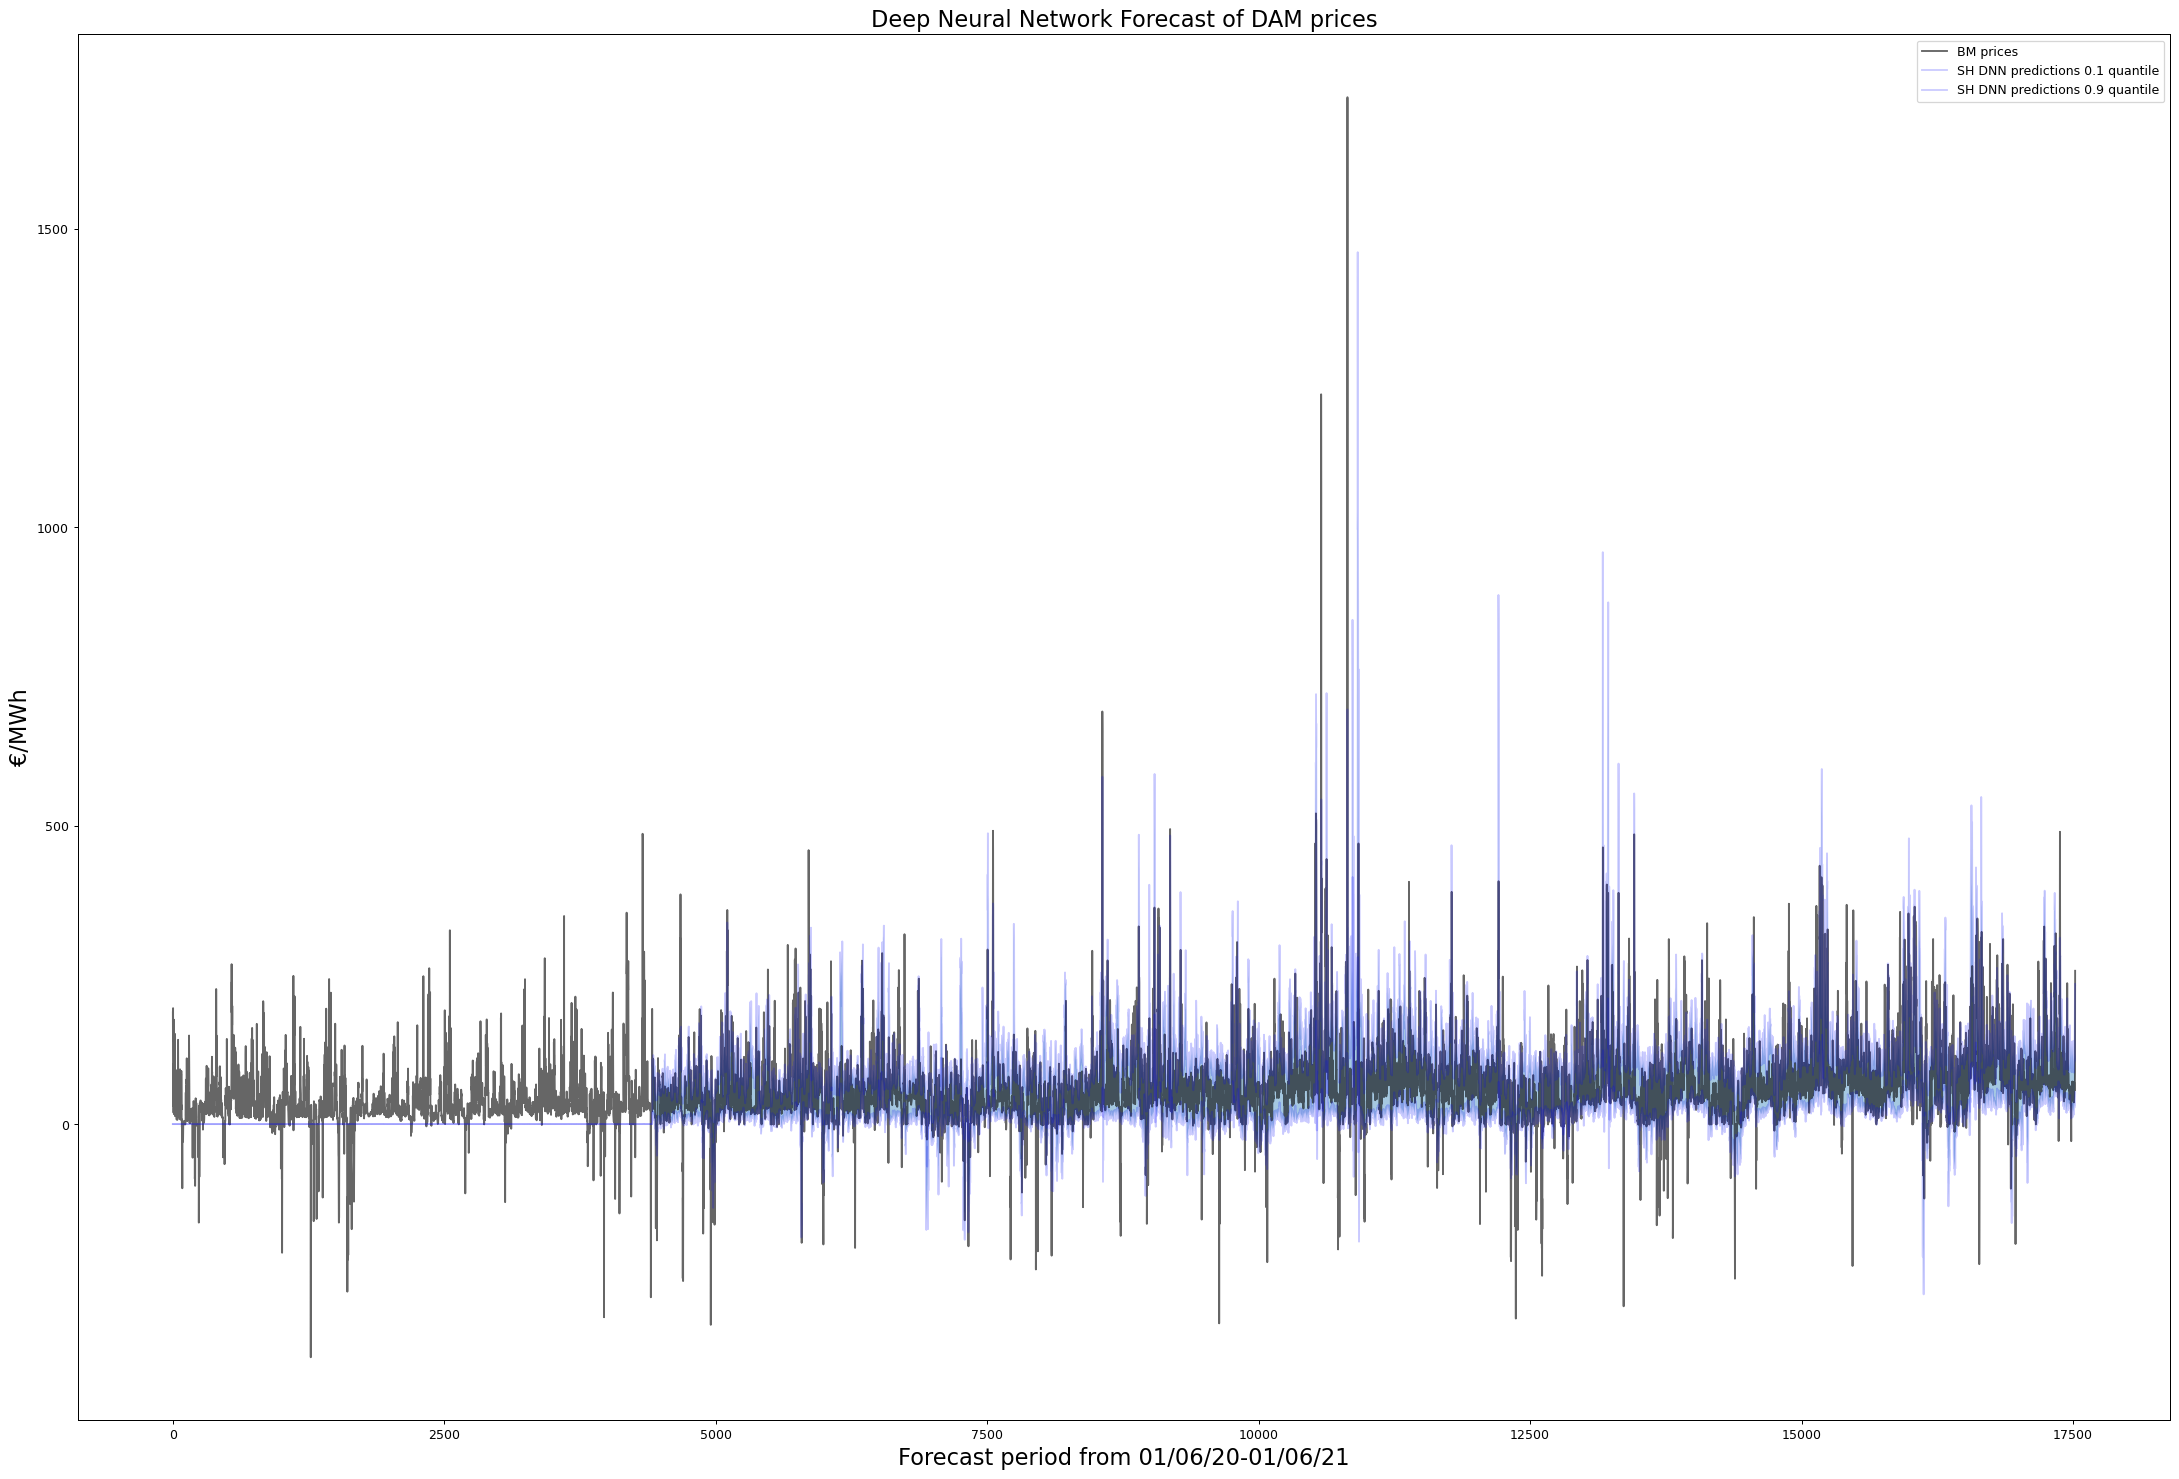

In [12]:
date_format="%m/%d/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/BM_QRA/Model_preds/MH_A_Q_1-12.csv")
dat1=dat1.iloc[456:,:].reset_index(drop=True)
dat1=pd.DataFrame(dat1)

column_names = ['lag_{}y_Forecast_10'.format(i) for i in range(2, 18)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_30'.format(i) for i in range(2, 18)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_50'.format(i) for i in range(2, 18)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_70'.format(i) for i in range(2, 18)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_90'.format(i) for i in range(2, 18)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y'.format(i) for i in range(2, 18)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

In [13]:
date_format="%m/%d/%Y %H:%M"
date_parse = lambda date: dt.datetime.strptime(date, date_format)
dat1 = pd.read_csv("/home/ciaran/BM_QRA/Model_preds/MH_B_Q_1-12.csv")
dat1=dat1.iloc[456:,:].reset_index(drop=True)
dat1=pd.DataFrame(dat1)

column_names = ['lag_{}y_Forecast_10'.format(i) for i in range(2, 18)]
Q_10=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_30'.format(i) for i in range(2, 18)]
Q_30=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_50'.format(i) for i in range(2, 18)]
Q_50=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_70'.format(i) for i in range(2, 18)]
Q_70=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y_Forecast_90'.format(i) for i in range(2, 18)]
Q_90=dat1[column_names].dropna().stack().reset_index()
column_names = ['lag_{}y'.format(i) for i in range(2, 18)]
YY_test=dat1[column_names].dropna().stack().reset_index()
np.errstate(divide='ignore',invalid='ignore')

performance_metrics_10 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.1),
                          sMAPE(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:])*100]

performance_metrics_30 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.3),
                          sMAPE(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:])*100]

performance_metrics_50 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5),
                          sMAPE(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:])*100]

performance_metrics_70 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7),
                          sMAPE(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:])*100]

performance_metrics_90 = [sqrt(mean_squared_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])),
                          mean_absolute_error(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:]),
                          pinball(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9),
                          sMAPE(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:])*100]

additional_metrics_10 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_10.iloc[:, 2:], Q_90.iloc[:, 2:], alpha=0.9)
additional_metrics_30 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_30.iloc[:, 2:], Q_70.iloc[:, 2:], alpha=0.7)
additional_metrics_50 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_50.iloc[:, 2:], Q_50.iloc[:, 2:], alpha=0.5)
additional_metrics_70 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_70.iloc[:, 2:], Q_30.iloc[:, 2:], alpha=0.7)
additional_metrics_90 = calculate_additional_metrics(YY_test.iloc[:, 2:], Q_90.iloc[:, 2:], Q_10.iloc[:, 2:], alpha=0.9)

performance_metrics_10.extend(additional_metrics_10)
performance_metrics_30.extend(additional_metrics_30)
performance_metrics_50.extend(additional_metrics_50)
performance_metrics_70.extend(additional_metrics_70)
performance_metrics_90.extend(additional_metrics_90)


metrics_df = pd.DataFrame([performance_metrics_10[:7], performance_metrics_30[:7], performance_metrics_50[:7],
                           performance_metrics_70[:7], performance_metrics_90[:7]],
                          columns=['RMSE', 'MAE', 'Pinball Score', 'sMAPE',
                                   
                                   'Winkler Score', 'Mean Width', 'coverage' ])
means = {
    'RMSE': metrics_df['RMSE'].mean(),
    'MAE': metrics_df['MAE'].mean(),
    'Pinball Score': metrics_df['Pinball Score'].iloc[:5].mean(),
    'sMAPE': metrics_df['sMAPE'].mean(),
    'Winkler Score': metrics_df['Winkler Score'].iloc[:3].mean(),
    'Mean Width': metrics_df['Mean Width'].iloc[:2].mean(),
}
metrics_df = metrics_df.append(means, ignore_index=True)
coverage_mean_first_3 = metrics_df['coverage'].iloc[:3].mean()
metrics_df.loc[5, 'coverage'] = coverage_mean_first_3
for i in range(0, len(metrics_df.columns), 2):
    metric_pair = metrics_df.iloc[:, i:i + 2]
    metric_names = metric_pair.columns
    print("Performance Metrics for Quantile {}:".format(metric_names[0]))
    for j in range(len(metric_pair)):
        value = metric_pair.iloc[j, 0]
        if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
            print("{}: {}".format(metric_names[0], ", ".join("{:.2f}".format(val) for val in value)))
        else:
            print("{}: {:.2f}".format(metric_names[0], value))
    print()
    if len(metric_names) > 1:  # Check if there is more than one metric in the pair
        print("Performance Metrics for Quantile {}:".format(metric_names[1]))
        for j in range(len(metric_pair)):
            value = metric_pair.iloc[j, 1]
            if hasattr(value, '__iter__') and not isinstance(value, (str, bytes)):
                print("{}: {}".format(metric_names[1], ", ".join("{:.2f}".format(val) for val in value)))
            else:
                print("{}: {:.2f}".format(metric_names[1], value))
        print()
np.errstate(divide='ignore', invalid='ignore')
pd.options.mode.chained_assignment = None

Q_90_n = Q_90.iloc[:, 2:]
Q_70_n = Q_70.iloc[:, 2:]
Q_30_n = Q_30.iloc[:, 2:]
Q_10_n = Q_10.iloc[:, 2:]
YY_test_n = YY_test.iloc[:, 2:]

hours_data = [YY_test_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_10_hours = [Q_10_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_90_hours = [Q_90_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_30_hours = [Q_30_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]
Q_70_hours = [Q_70_n.iloc[i::24, :].reset_index(drop=True) for i in range(24)]

var_conf_level_10_90 = 0.80  
conf_level = 0.95  
results_10_90 = []

for hour, (y_true, q_10, q_90) in enumerate(zip(hours_data, Q_10_hours, Q_90_hours)):
    violations = calculate_violations(y_true, q_10, q_90)
    total_violations, all_violations = calculate_total_violations([y_true], [q_10], [q_90])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_10_90, conf_level=conf_level)
    
    results_10_90.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })

rejected_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Reject H0']
total_rejected_hours_10_90 = len(rejected_hours_10_90)
passed_hours_10_90 = [result['Hour'] for result in results_10_90 if result['Result'] == 'Fail to reject H0']
total_passed_hours_10_90 = len(passed_hours_10_90)
print(f'Total hours that reject the null hypothesis (Q_10/Q_90): {total_rejected_hours_10_90}')
print(f'Total hours that pass the null hypothesis (Q_10/Q_90): {total_passed_hours_10_90}')

var_conf_level_30_70 = 0.40 
results_30_70 = []
for hour, (y_true, q_30, q_70) in enumerate(zip(hours_data, Q_30_hours, Q_70_hours)):
    violations = calculate_violations(y_true, q_30, q_70)
    total_violations, all_violations = calculate_total_violations([y_true], [q_30], [q_70])

    kupiec_result = perform_kupiec_test(all_violations, var_conf_level=var_conf_level_30_70, conf_level=conf_level)
    
    results_30_70.append({
        'Hour': hour + 1,
        'Chi Square Critical Value': kupiec_result['chi square critical value'],
        'Result': kupiec_result['result']
    })
rejected_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Reject H0']
total_rejected_hours_30_70 = len(rejected_hours_30_70)
passed_hours_30_70 = [result['Hour'] for result in results_30_70 if result['Result'] == 'Fail to reject H0']
total_passed_hours_30_70 = len(passed_hours_30_70)
print(f'Total hours that reject the null hypothesis (Q_30/Q_70): {total_rejected_hours_30_70}')
print(f'Total hours that pass the null hypothesis (Q_30/Q_70): {total_passed_hours_30_70}')
p1=Q_10.iloc[:, 2:]
p1=p1.reset_index(drop=True)
p3=Q_30.iloc[:, 2:]
p3=p3.reset_index(drop=True)
p5=Q_50.iloc[:, 2:]
p5=p5.reset_index(drop=True)
p7=Q_70.iloc[:, 2:]
p7=p7.reset_index(drop=True)
p9=Q_90.iloc[:, 2:]
p9=p9.reset_index(drop=True)
yy=YY_test.iloc[:, 2:]
yy=yy.reset_index(drop=True)
p1=p1.values.ravel()
p3=p3.values.ravel()
p5=p5.values.ravel()
p7=p7.values.ravel()
p9=p9.values.ravel()                    
figure(figsize = (30, 20), dpi = 90)
plt.plot(yy, color='black', label='BM prices', alpha=0.6)
plt.plot(p1, color='blue', label='SH DNN predictions 0.1 quantile', alpha=0.2)
plt.plot(p9, color='blue', label='SH DNN predictions 0.9 quantile', alpha=0.2)
plt.fill_between(np.arange(0,len(YY_test),1), p1, p9, alpha=0.4)
plt.xlabel('Forecast period from 01/06/20-01/06/21',fontsize=18)
plt.ylabel('€/MWh', fontsize=18)
plt.title("Deep Neural Network Forecast of DAM prices", fontsize=18)
plt.legend()

FileNotFoundError: [Errno 2] No such file or directory: '/home/ciaran/BM_QRA/Model_preds/MH_B_Q_1-12.csv'